In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import imageio
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from PIL import Image
from skimage import img_as_bool, color, morphology, io
from skimage.morphology import skeletonize, binary_closing
from skimage.measure import label, regionprops, find_contours

from skimage.segmentation import clear_border
import matplotlib.patches as mpatches
from skimage.color import label2rgb
import PIL.ImageOps 
from scipy import ndimage as ndi
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

d:\users\asus\appdata\local\programs\python\python37\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
def alternateSequentialFiltering(image):
    # ASF(alternate sequential filtering) Smooth the whole picture
    open1 = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    close1 = cv2.morphologyEx(open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    open2 = cv2.morphologyEx(close1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    close2 = cv2.morphologyEx(open2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    open3 = cv2.morphologyEx(close2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    close3 = cv2.morphologyEx(open3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    return close3

def preProcess(i):
    image = cv2.imread('training/images/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    
    plt.subplot(1,3,1)
    plt.imshow(g, cmap="gray")
    cv2.imwrite('./image/greenchannel/'+str(i)+'_bloodvessel.png', g)
    
    plt.subplot(1,3,2)
    plt.imshow(contrast_g_fundus, cmap="gray")
    cv2.imwrite('./image/clahe/'+str(i)+'_bloodvessel.png', contrast_g_fundus)
    
    plt.subplot(1,3,3)
    plt.imshow(R3, cmap="gray")
    cv2.imwrite('./image/filtering/'+str(i)+'_bloodvessel.png', R3)
    plt.show()

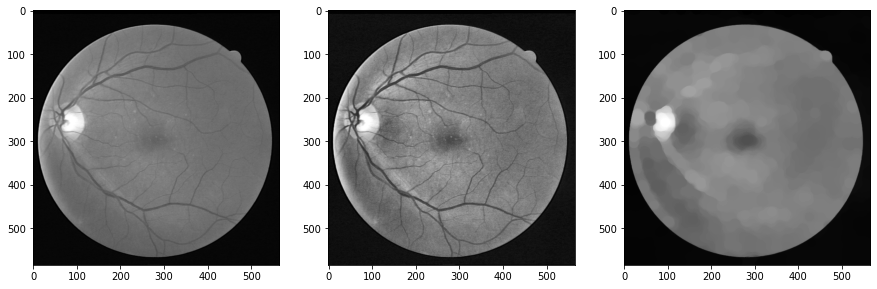

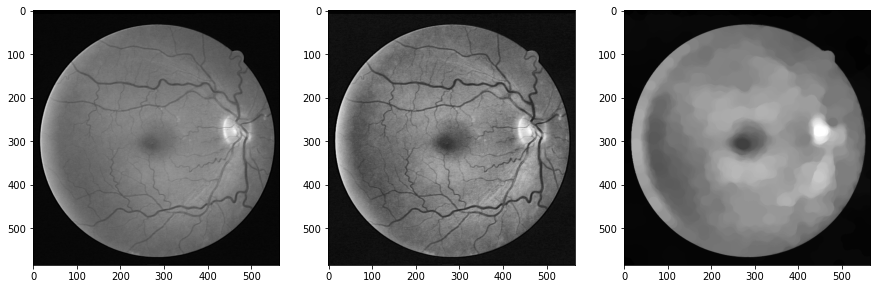

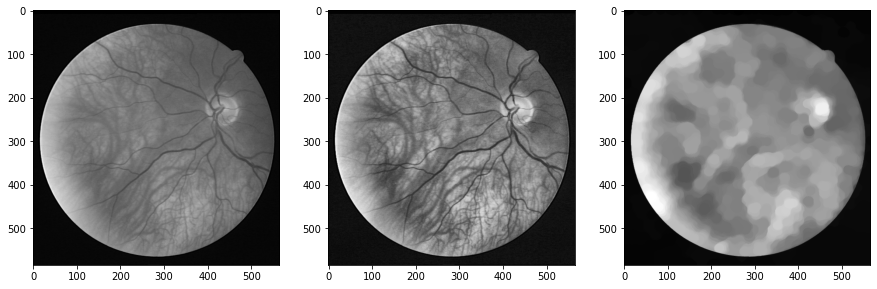

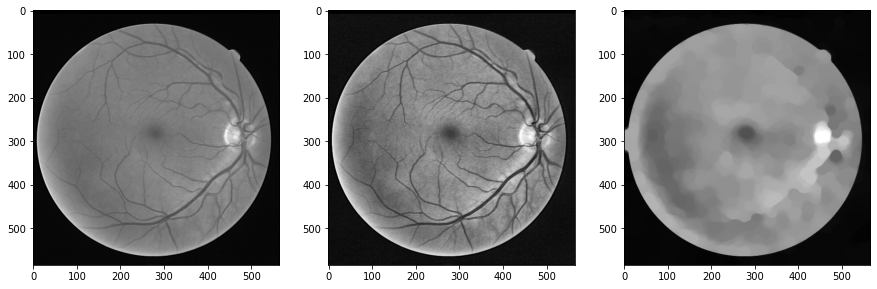

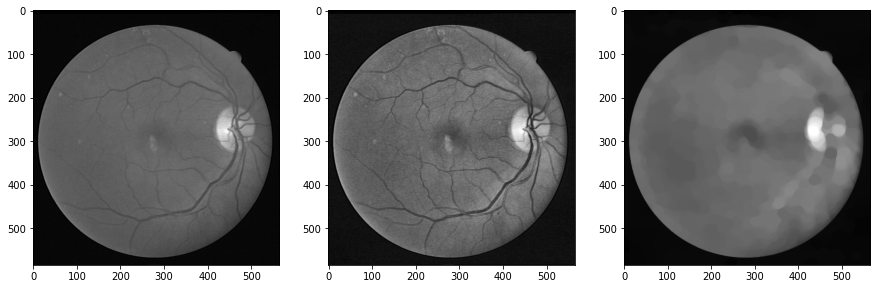

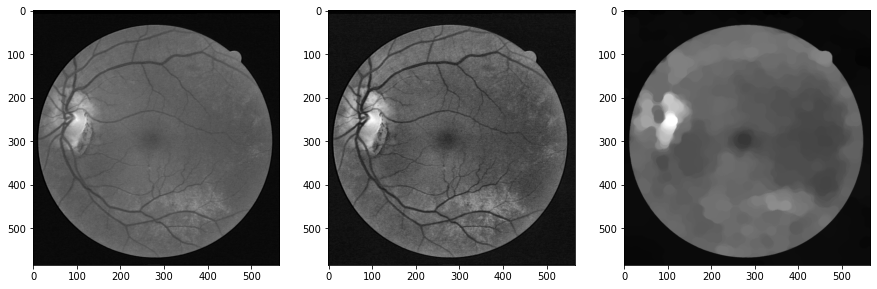

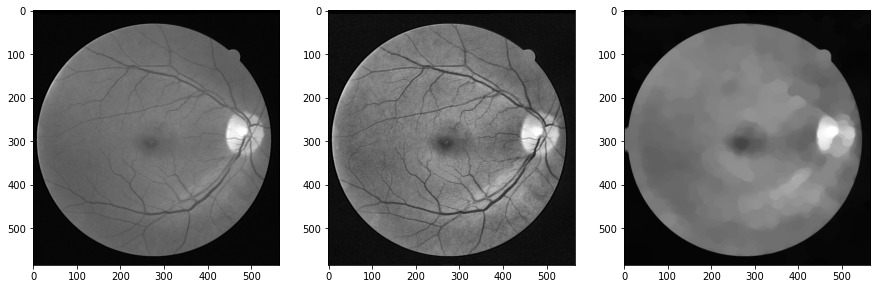

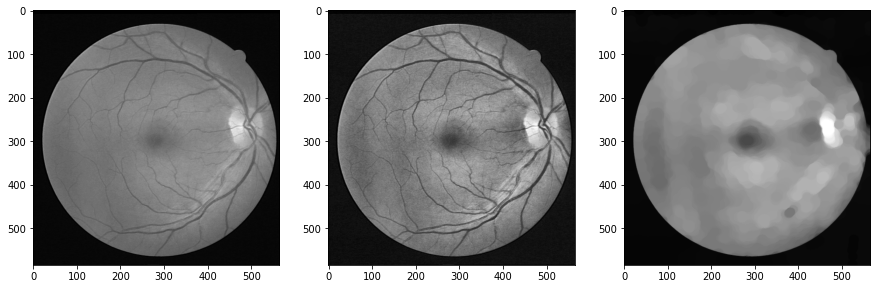

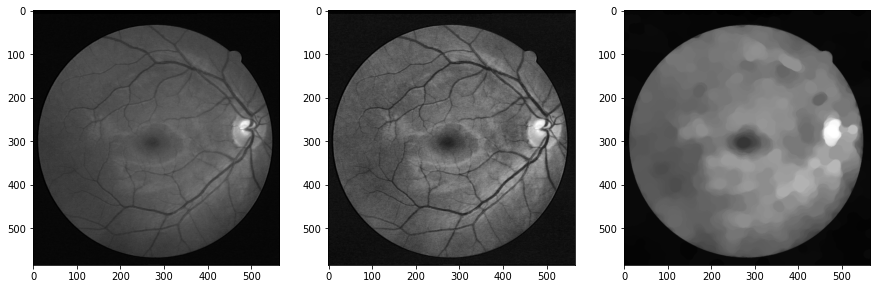

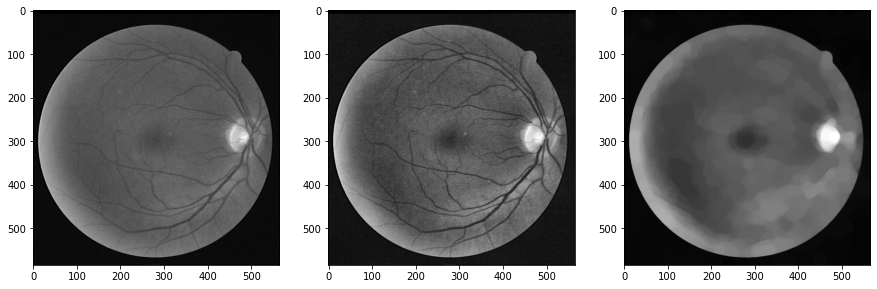

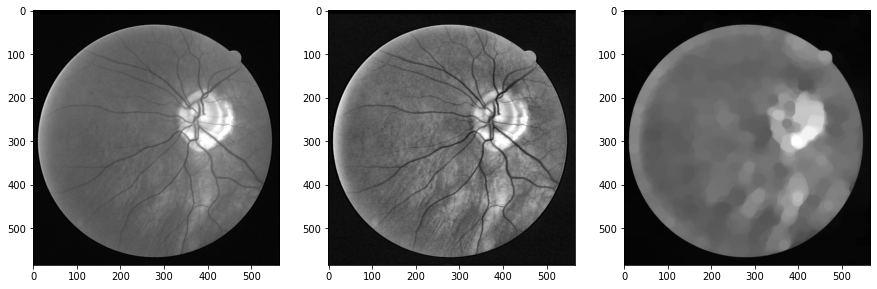

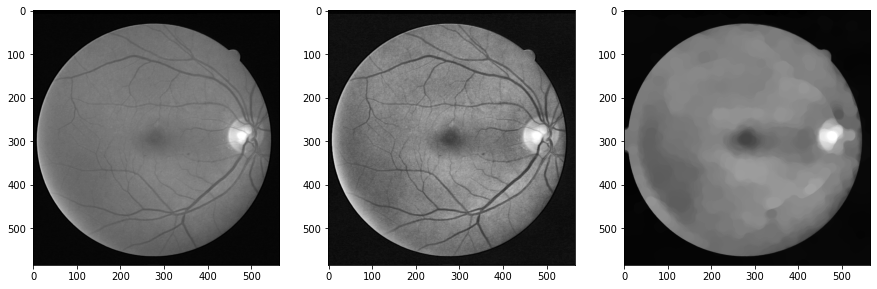

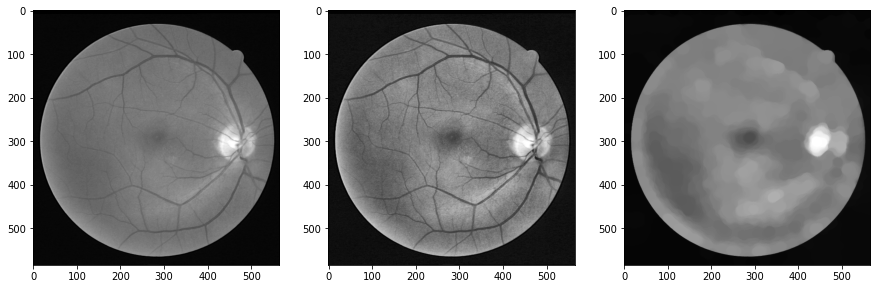

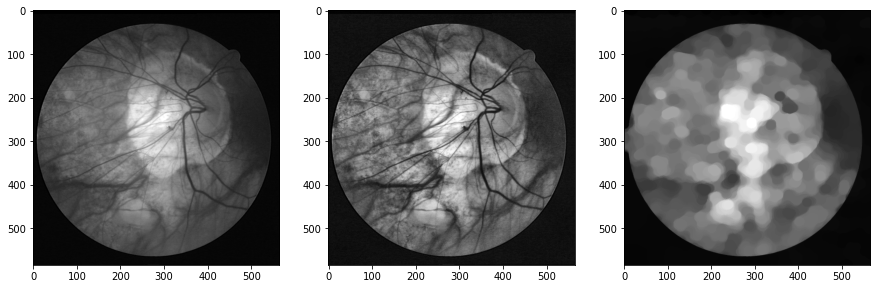

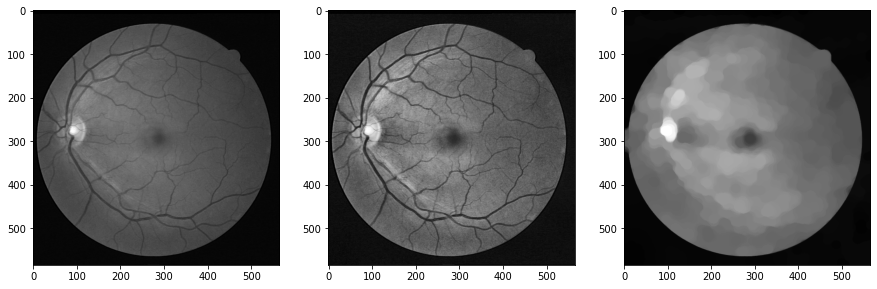

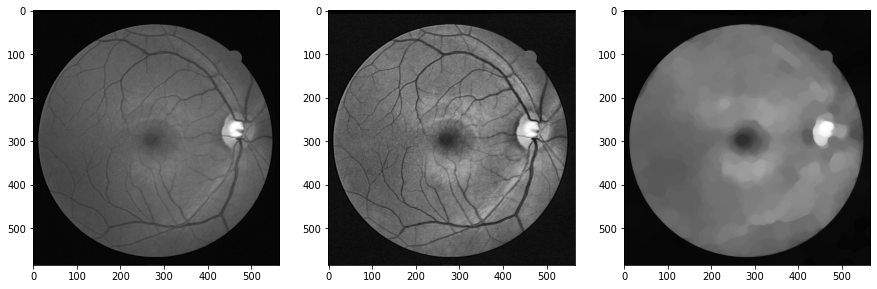

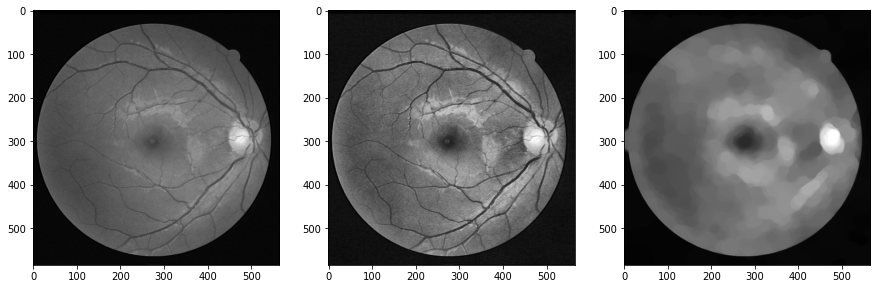

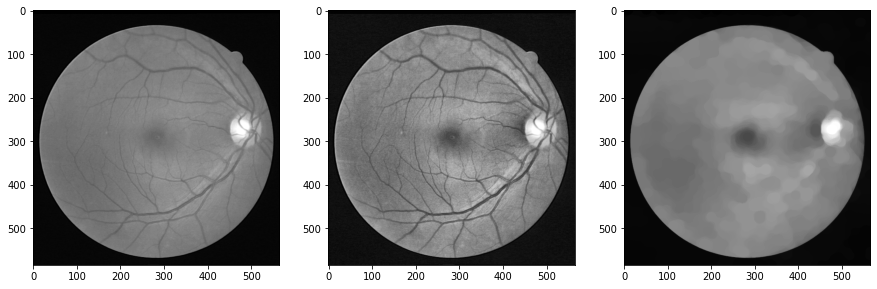

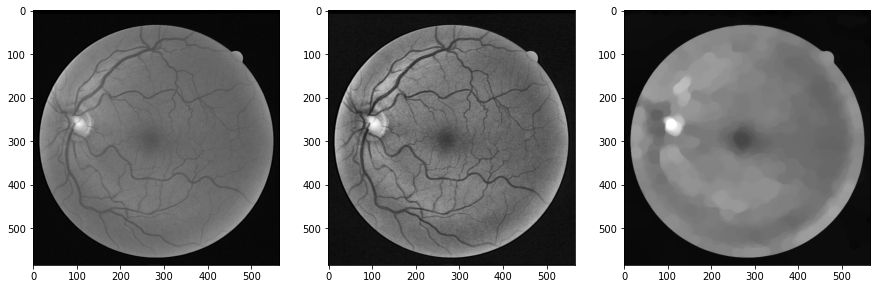

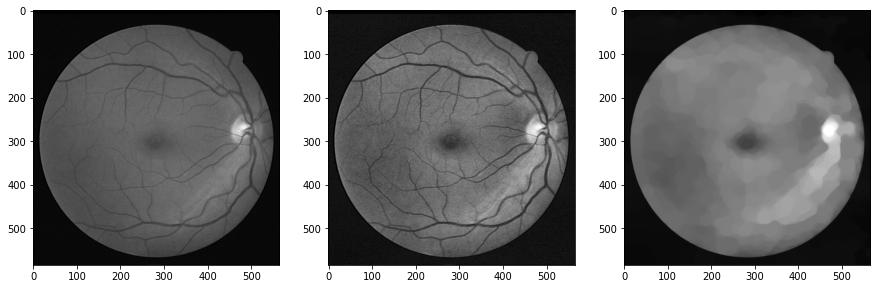

In [3]:
for i in range(21,41):
    preProcess(i)

In [4]:
def postProcess(i):
    image = cv2.imread('training/images/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    im = Image.open('training/1st_manual/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    label = np.asarray(im)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    f4 = cv2.subtract(R3, contrast_g_fundus)
    f5 = clahe.apply(f4)
    f6 = clahe.apply(f5)
    f7 = clahe.apply(f6)
    
    _, thresh = cv2.threshold(f7, 15, 255, cv2.THRESH_BINARY)  #mapping array 0 atau 255 (item putih)
    maskSmallContour = np.ones(f7.shape[:2], dtype="uint8") * 255 #mapping array bernilai 255 (utk masking)
    contoursSmall, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #
    for cnts in contoursSmall:
        if cv2.contourArea(cnts) <= 200: 
            cv2.drawContours(maskSmallContour, [cnts], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=maskSmallContour)
    _, fin = cv2.threshold(im, 30, 255, cv2.THRESH_BINARY)

    plt.subplot(1,2,1)
    plt.imshow(im, cmap="gray")
    cv2.imwrite('./image/im/'+str(i)+'_bloodvessel.png', im)
    plt.subplot(1,2,2)
    plt.imshow(fin, cmap="gray")
    cv2.imwrite('./image/firstresult/'+str(i)+'_bloodvessel.png', fin)

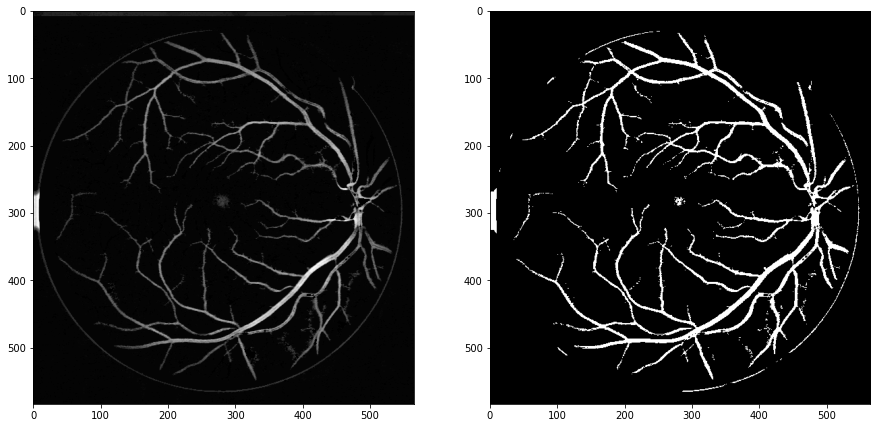

In [5]:
postProcess(24)

In [6]:
from PIL import Image
def removeBoarder(i):
    im = Image.open('training/mask/'+str(i)+'_training_mask.gif')
    im = im.convert('RGB')
    I = np.asarray(im)
    image = cv2.imread('image/firstresult/'+str(i)+'_bloodvessel.png')
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(I, kernel, iterations=3)
    result = cv2.bitwise_and(erosion, image)
    
    plt.subplot(1,3,1)
    plt.imshow(image, cmap="gray")
    plt.subplot(1,3,2)
    plt.imshow(erosion, cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(result, cmap="gray")
    cv2.imwrite('image/lastresult/'+str(i)+'_bloodvessel.png', result)

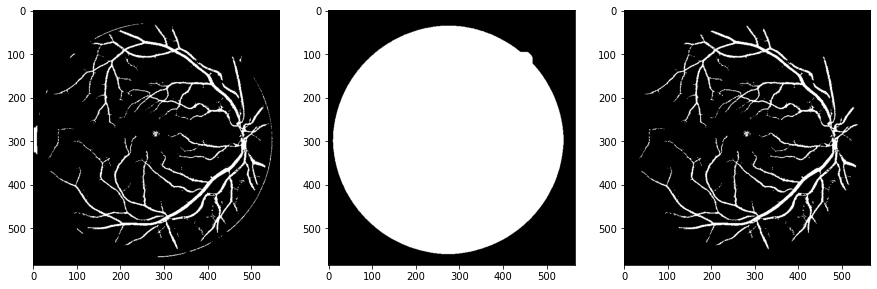

In [7]:
removeBoarder(24)

In [8]:

def skeleton(i):
    image = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
    image = img_as_bool(image)
    out = ndi.distance_transform_edt(~image)
    out = out < 0.05 * out.max()
    out = skeletonize(out)
    out = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
    test_labelized = label(out)
#     test_depleted = np.where(test_labelized == 2,0,test_labelized)
#     test_depleted = test_depleted[0]
    test_depleted_bis = np.where(test_labelized > 1,0,test_labelized)
    plt.subplot(1,2,1)
    plt.imshow(out, cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(test_depleted_bis, cmap="gray")
    plt.imsave(fname='image/remove_region/'+str(i)+'_bloodvessel.png',arr=test_depleted_bis,cmap='gray', format='png')
    plt.show()
# def skeletonize(i):
#     image = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
#     image = img_as_bool(color.rgb2gray(image))
#     out = morphology.medial_axis(image)
    
#     plt.subplots(figsize=(12, 12))
#     plt.imshow(out, cmap="gray")
# #     io.imsave('image/skeleton/'+str(i)+'_bloodvessel.png',out)

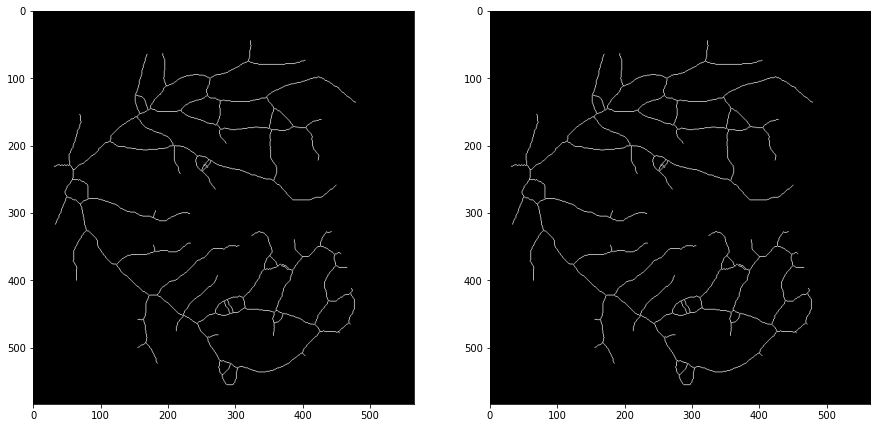

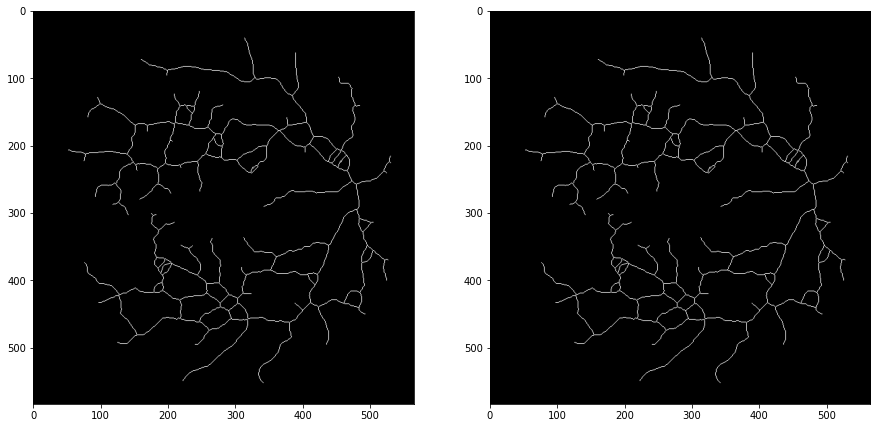

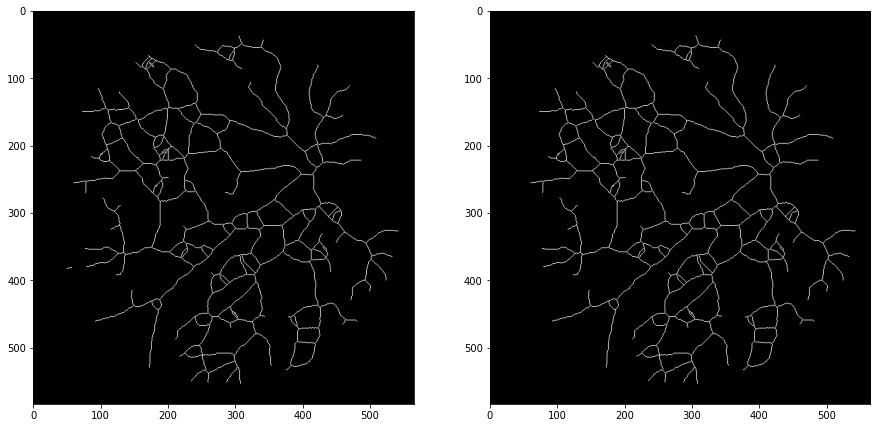

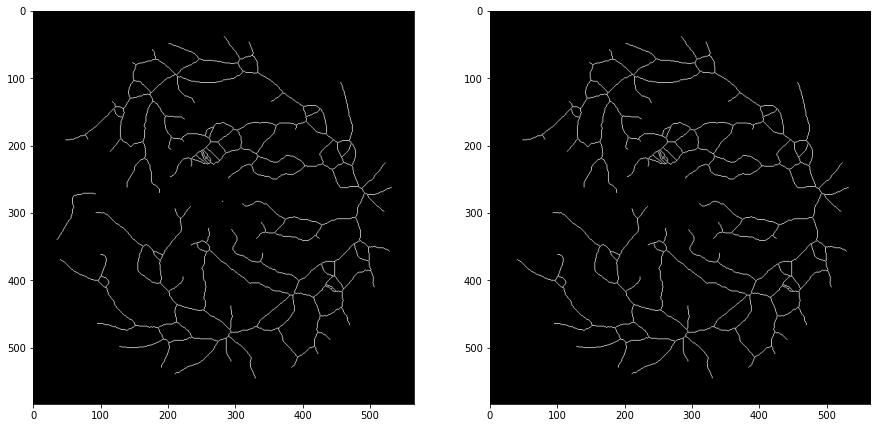

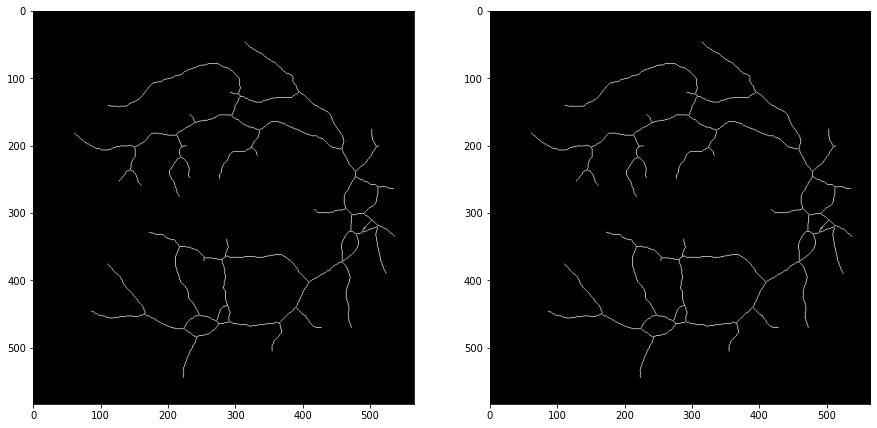

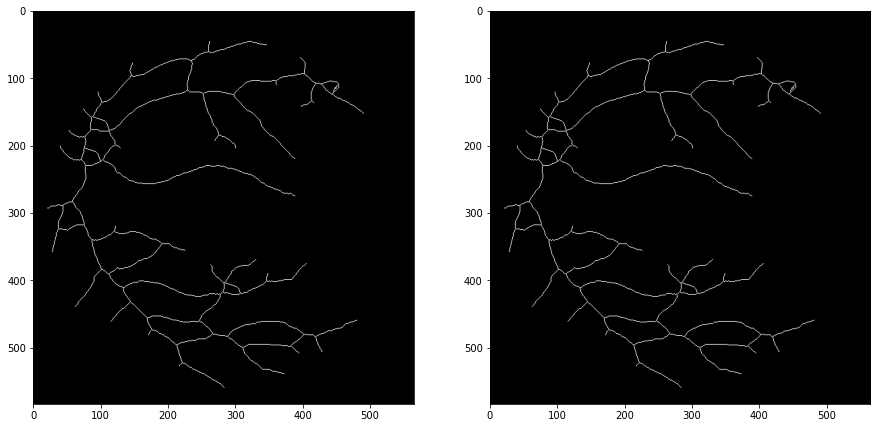

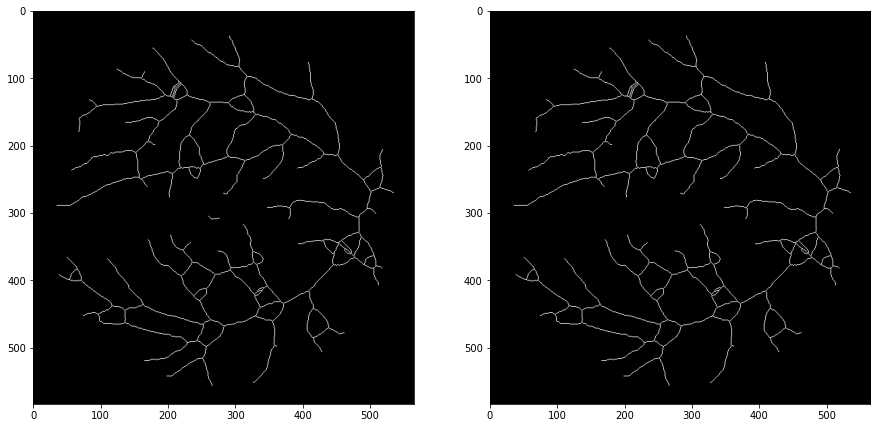

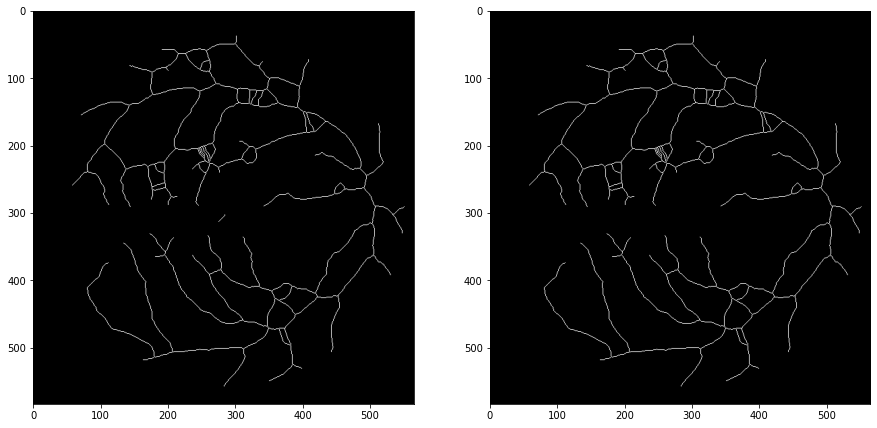

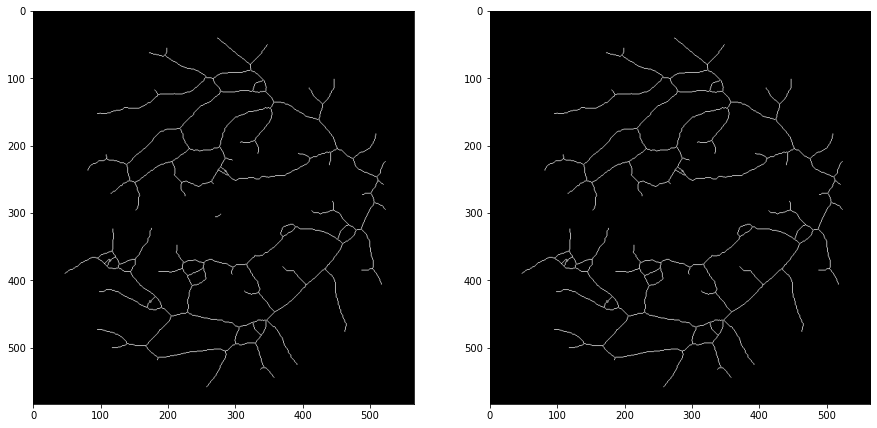

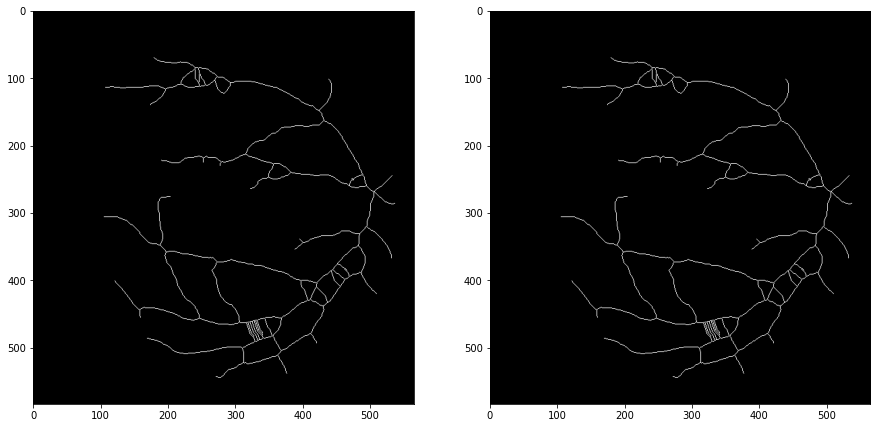

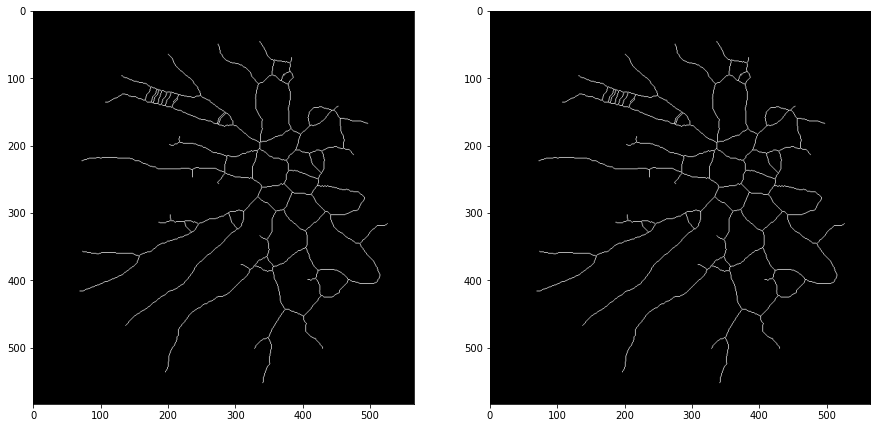

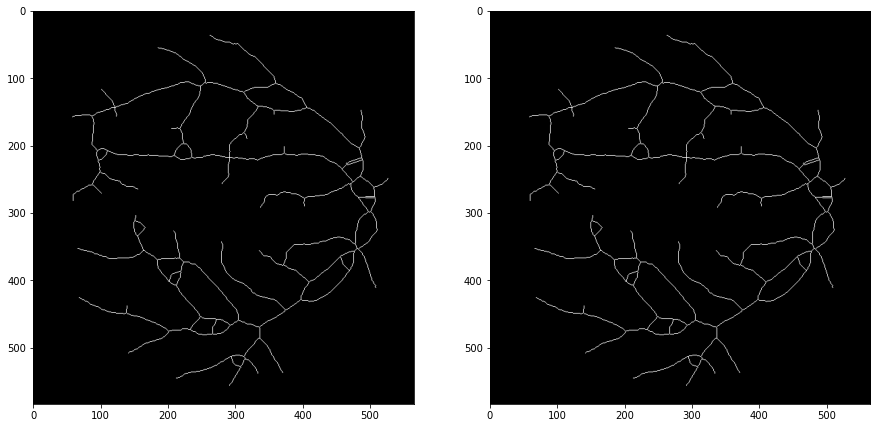

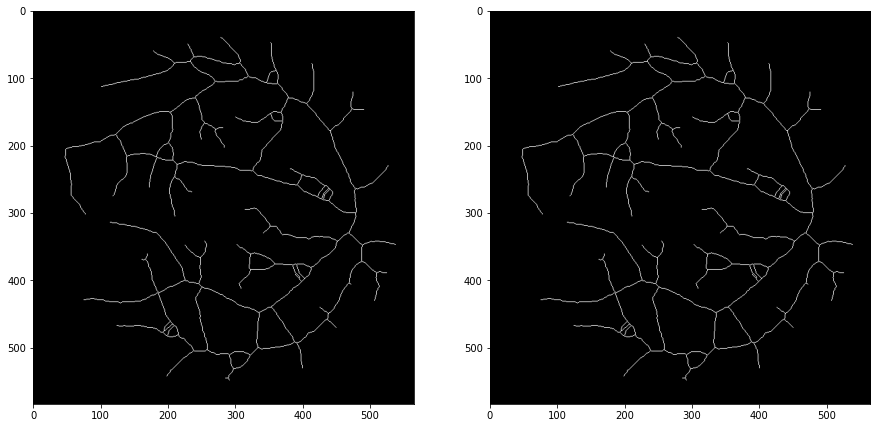

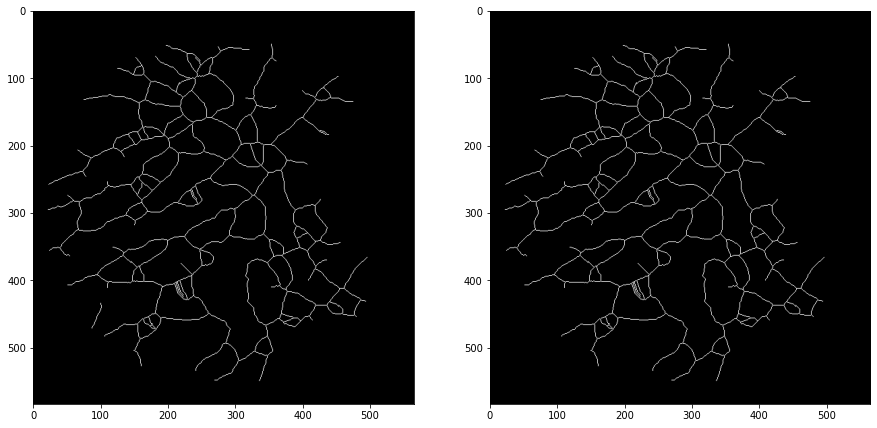

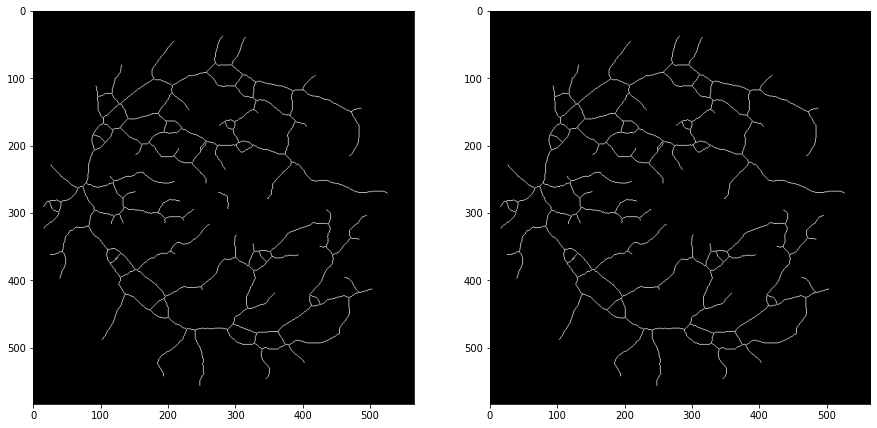

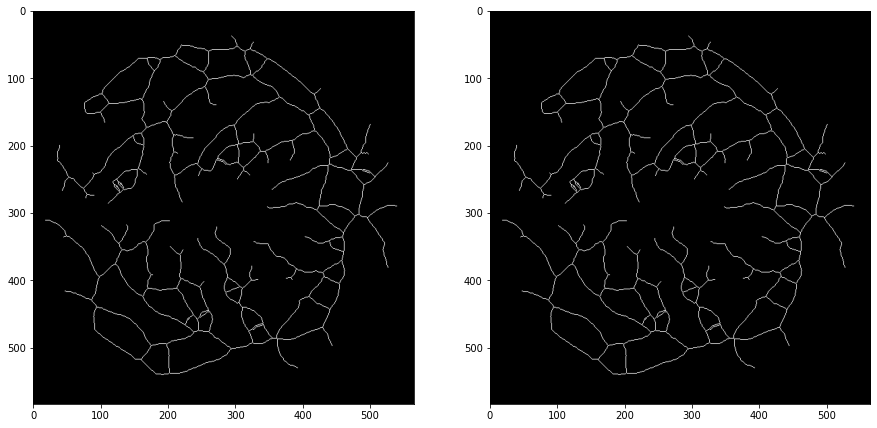

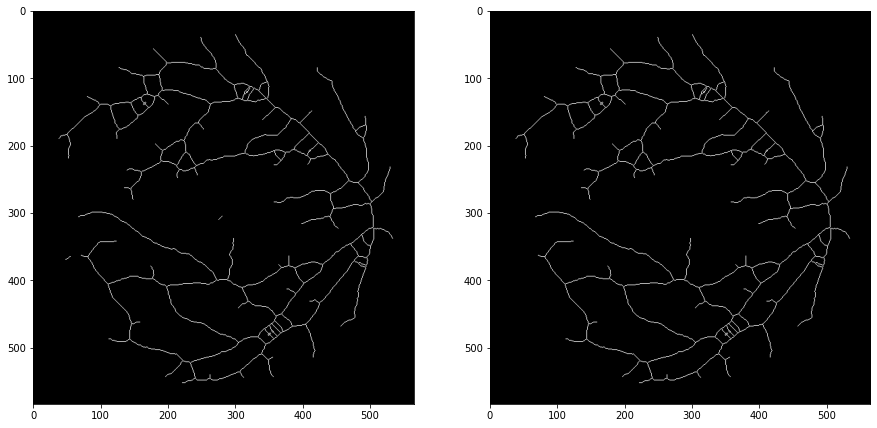

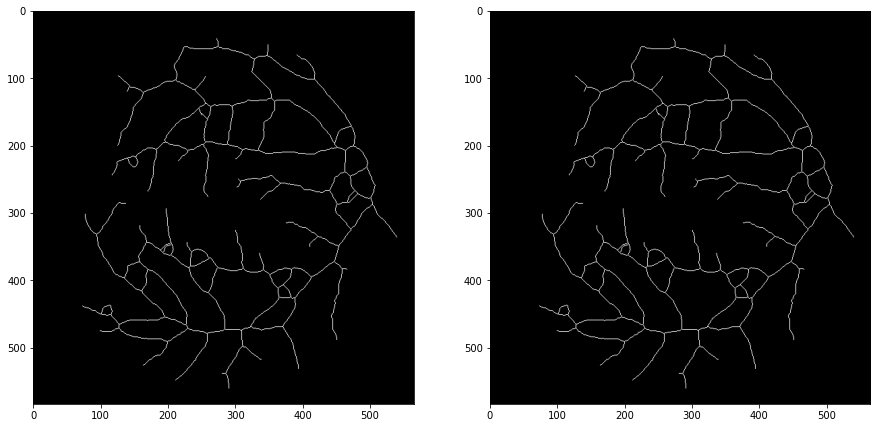

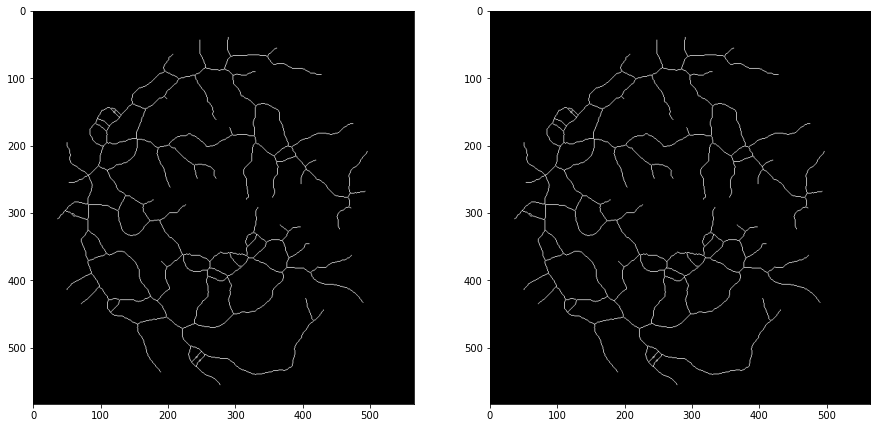

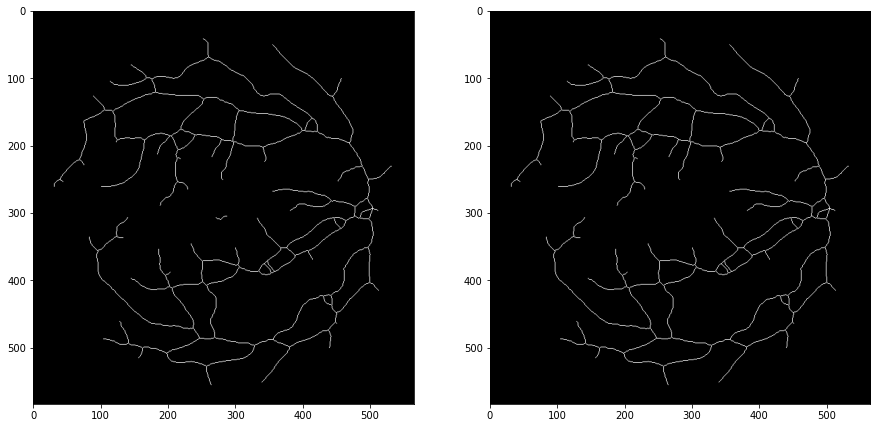

In [9]:
for i in range(21,41):
    skeleton(i)

In [10]:
bifurcations_list = list()
crossover_list = list()

bifurcations = [
    
#     [[1,0,1],
#      [0,1,0],
#      [1,0,1]],
#     [[0,1,0],
#      [1,1,1],
#      [0,1,0]],
    
    [[1,0,1],
     [0,1,0],
     [0,1,0]],
    [[1,0,1],
     [0,1,0],
     [1,0,0]],
    [[1,0,0],
     [0,1,1],
     [1,0,0]],

     [[0,0,1],
      [1,1,0],
      [0,1,0]],

     [[1,0,0],
      [0,1,1],
      [0,1,0]],

     [[0,1,0],
      [0,1,1],
      [0,1,0]],

      [[0,1,0],
       [1,1,0],
       [0,0,1]],

     [[1,0,0],
      [0,1,1],
      [0,1,0]]


]

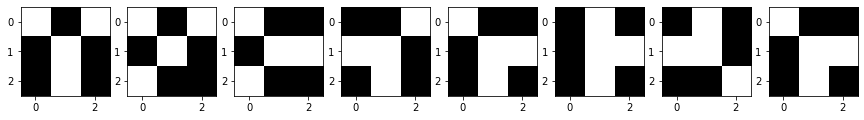

In [11]:
fig,ax = plt.subplots(1,8,figsize=(15,3))

for i, idx in enumerate(bifurcations):
  ax[i].imshow(bifurcations[i], cmap = 'gray')

In [12]:
for i in range(4):
    for j in  range(len(bifurcations)):
        bifurcations_list.append(np.rot90(bifurcations[j],i))



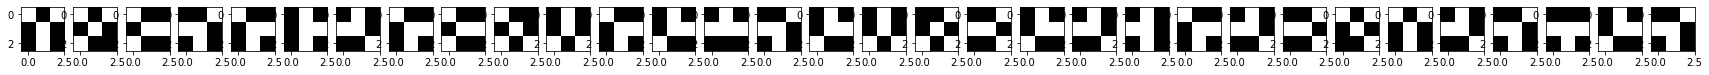

In [13]:
fig,ax = plt.subplots(1,len(bifurcations_list),figsize=(30,3))

for i, idx in enumerate(bifurcations_list):
  ax[i].imshow(bifurcations_list[i], cmap = 'gray')

In [14]:
crossover  = [
    [[0,0,1,0,0],
     [0,0,1,0,0],
     [1,1,1,1,1],
     [0,0,1,0,0],
     [0,0,1,0,0]],
    
    [[0,0,1,0,0],
     [1,0,1,0,0],
     [0,1,1,1,0],
     [0,0,1,0,1],
     [0,0,1,0,0]],
    
    [[1,0,1,0,0],
     [1,0,1,0,0],
     [0,1,1,1,0],
     [0,0,1,0,1],
     [0,0,1,0,1]],
    
    [[1,0,0,0,1],
     [0,1,0,1,0],
     [0,0,1,0,0],
     [0,1,0,1,0],
     [1,0,0,0,1]],
    
    [[1,0,0,0,1],
     [0,1,0,1,0],
     [0,0,1,0,0],
     [0,1,0,1,1],
     [0,1,0,0,0]],

]

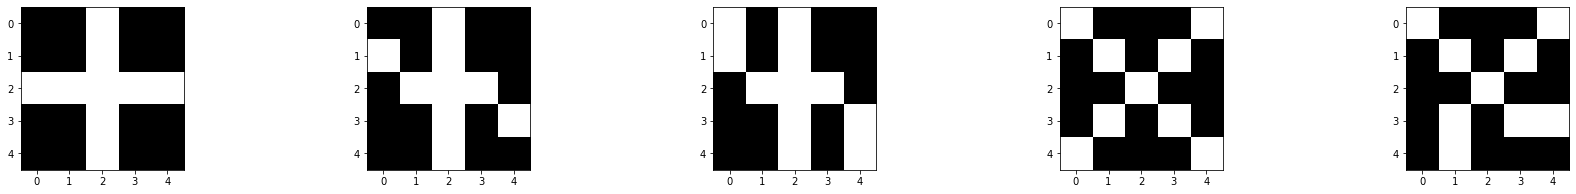

In [15]:
fig,ax = plt.subplots(1,len(crossover),figsize=(30,3))

for i, idx in enumerate(crossover):
  ax[i].imshow(crossover[i], cmap = 'gray')

In [16]:
for i in range(4):
    for j in  range(len(crossover)):
        crossover_list.append(np.rot90(crossover[j],i))
        crossover_list.append(np.flip(crossover[j],0))
        crossover_list.append(np.flip(crossover[j],1))

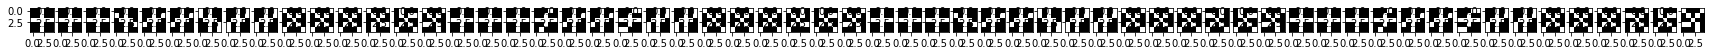

In [17]:
fig,ax = plt.subplots(1,len(crossover_list),figsize=(30,10))

for i, idx in enumerate(crossover_list):
  ax[i].imshow(crossover_list[i], cmap = 'gray')

In [18]:
def detection(i,furcations_list):
    img = image = cv2.imread('image/remove_region/'+str(i)+'_bloodvessel.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    arr = np.asarray(img)
    plt.figure(figsize=(20,20))
#     plt.imshow(img, cmap='gray')
    result = np.zeros(arr.shape)
    for fur in furcations_list:
        result = result + ndi.binary_hit_or_miss((arr), fur).astype(np.int)
    # founded = np.where(result == 1)
    result=morphology.dilation(result)

    # remove artifacts connected to image border
    cleared = clear_border(result)

    # label image regions
    label_image = label(cleared)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=arr, bg_label=0)

    fig, ax = plt.subplots(figsize=(12, 12))
    # ax.imshow(img_final)
    ax.imshow(image_label_overlay)


    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 1:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

<Figure size 1440x1440 with 0 Axes>

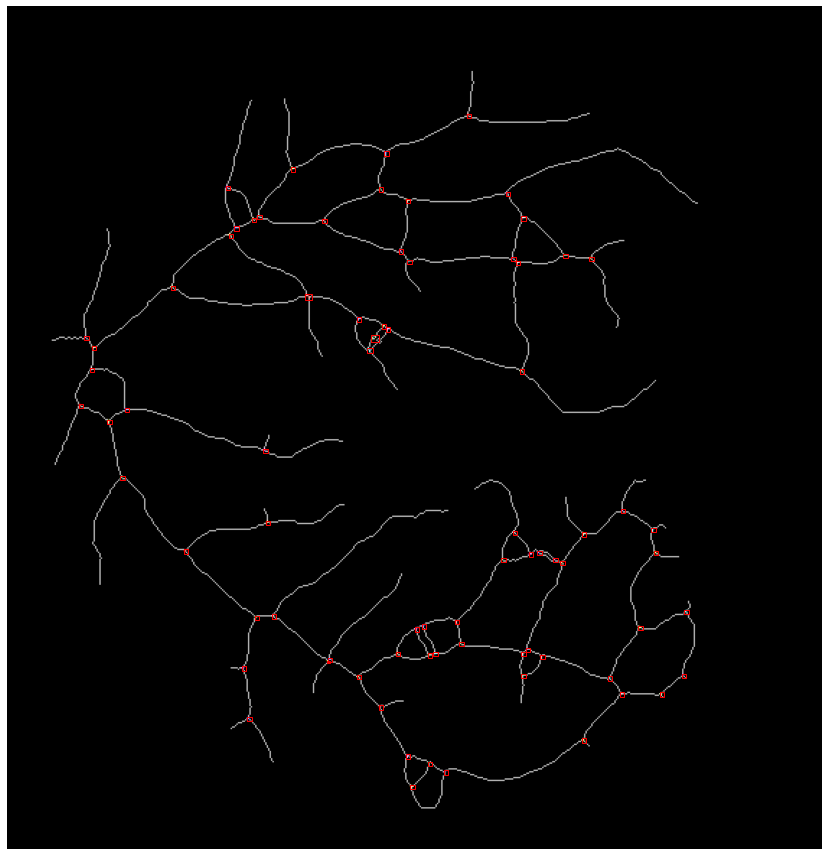

<Figure size 1440x1440 with 0 Axes>

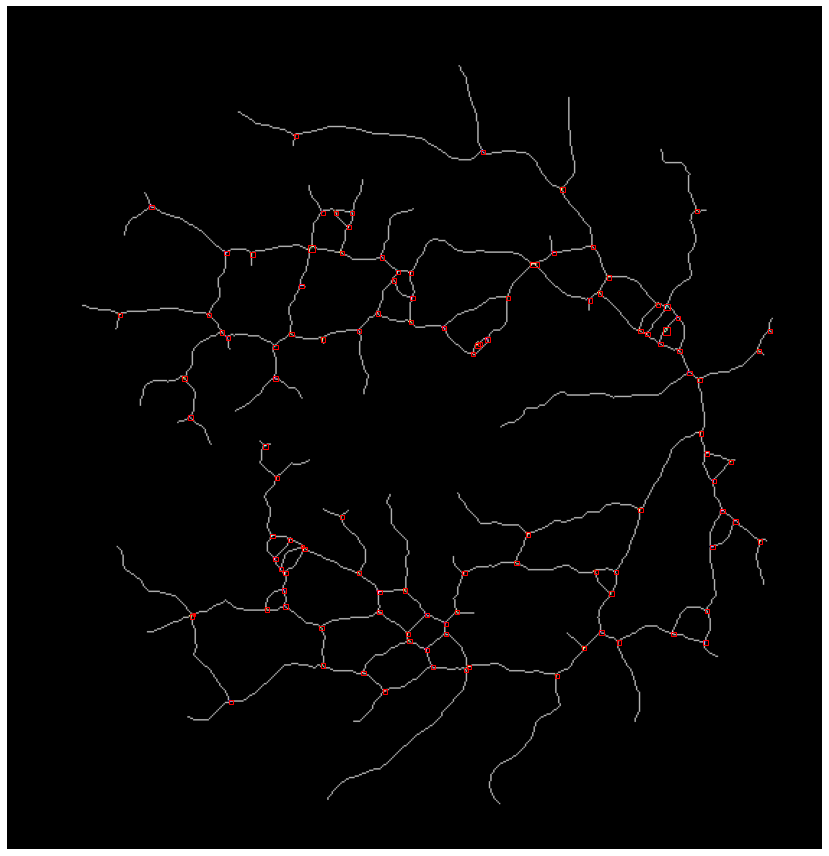

<Figure size 1440x1440 with 0 Axes>

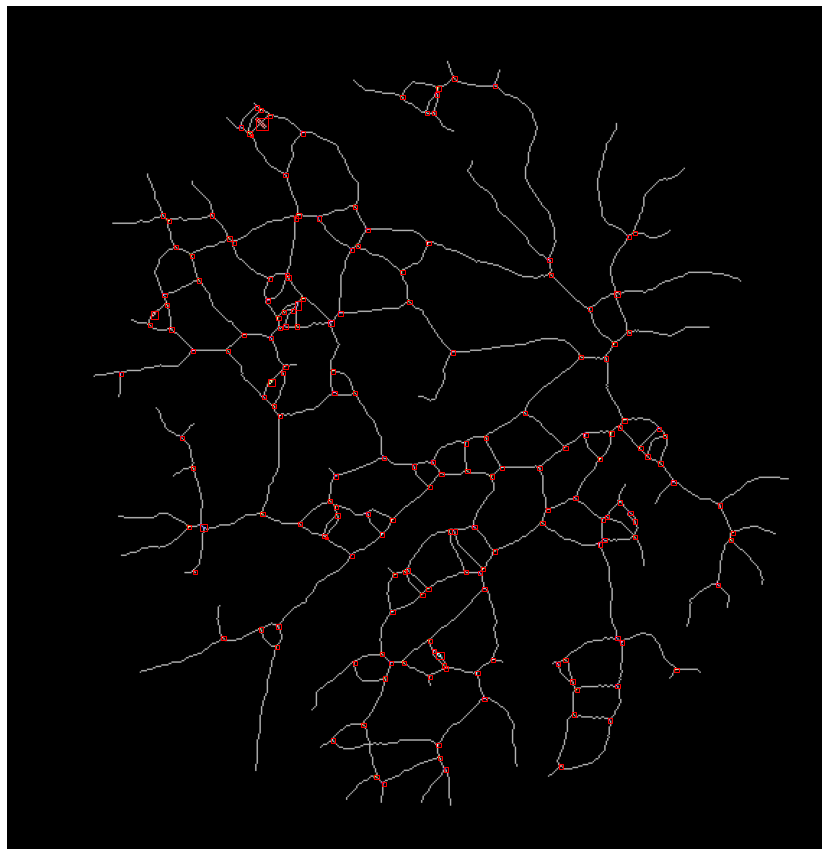

<Figure size 1440x1440 with 0 Axes>

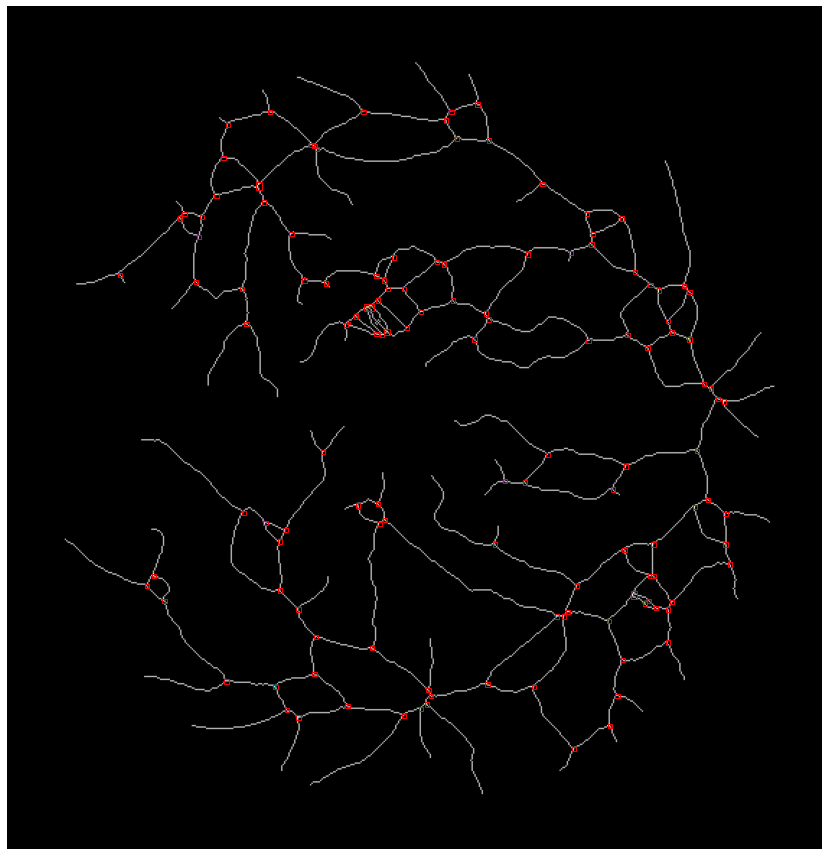

<Figure size 1440x1440 with 0 Axes>

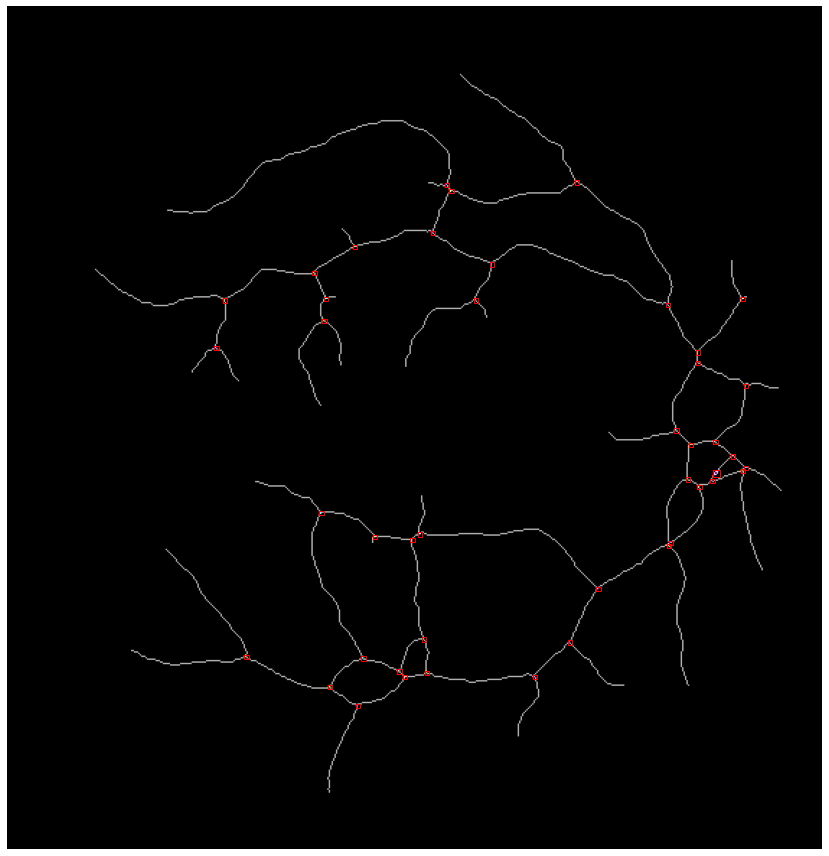

<Figure size 1440x1440 with 0 Axes>

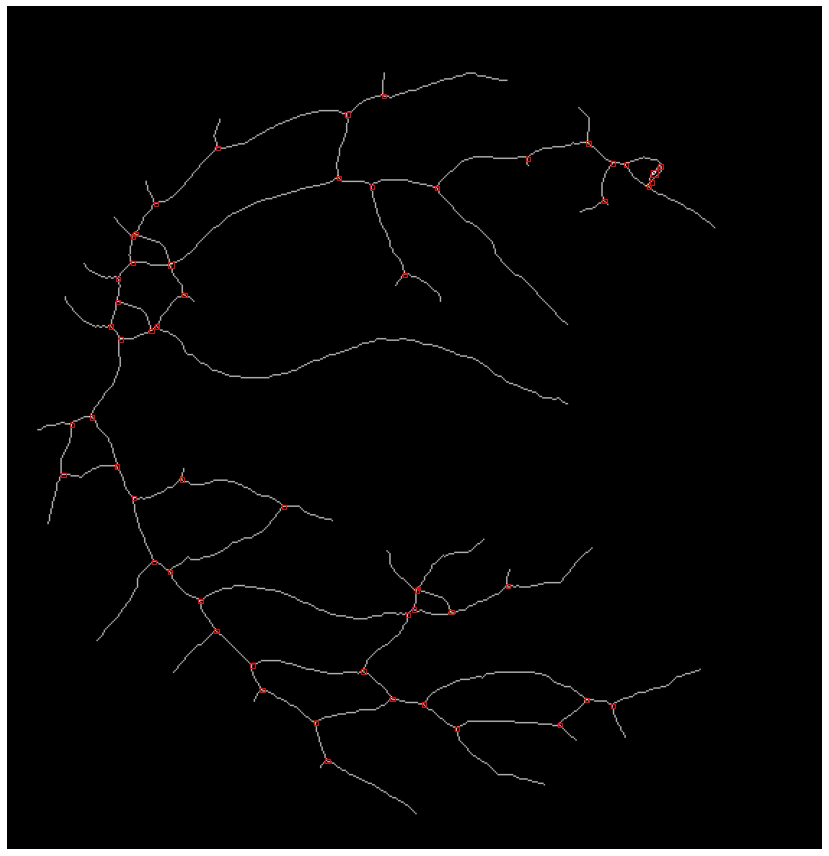

<Figure size 1440x1440 with 0 Axes>

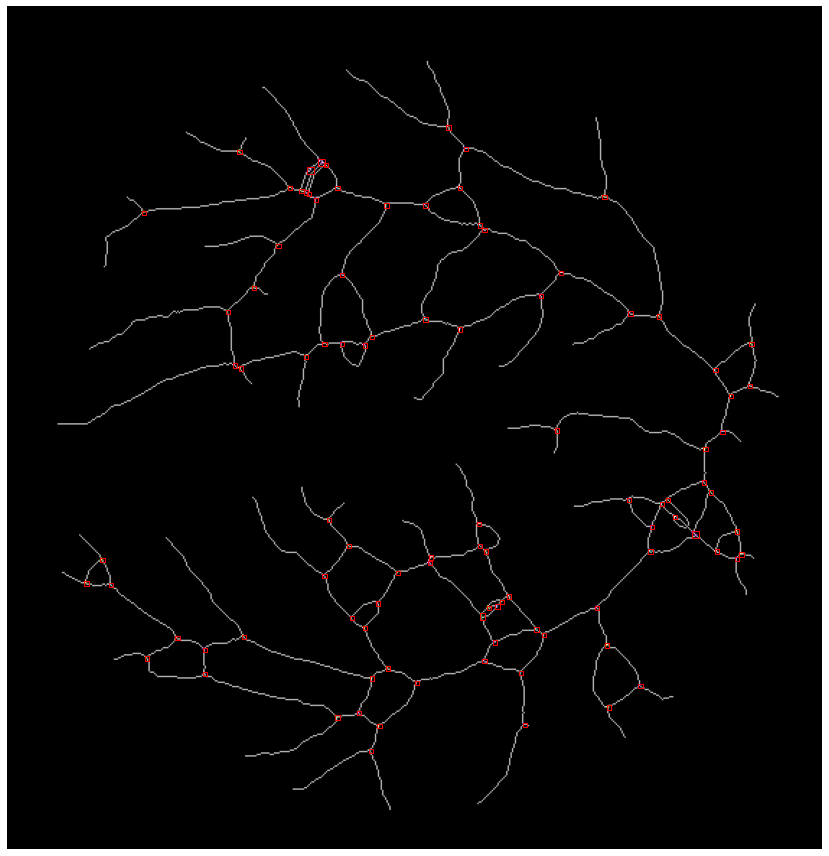

<Figure size 1440x1440 with 0 Axes>

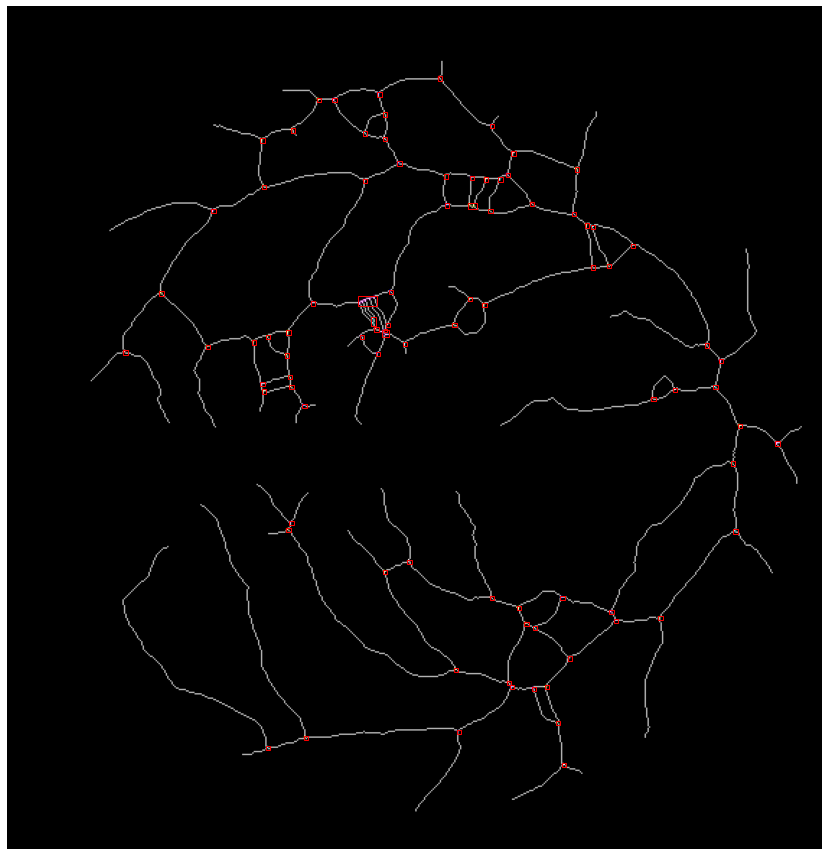

<Figure size 1440x1440 with 0 Axes>

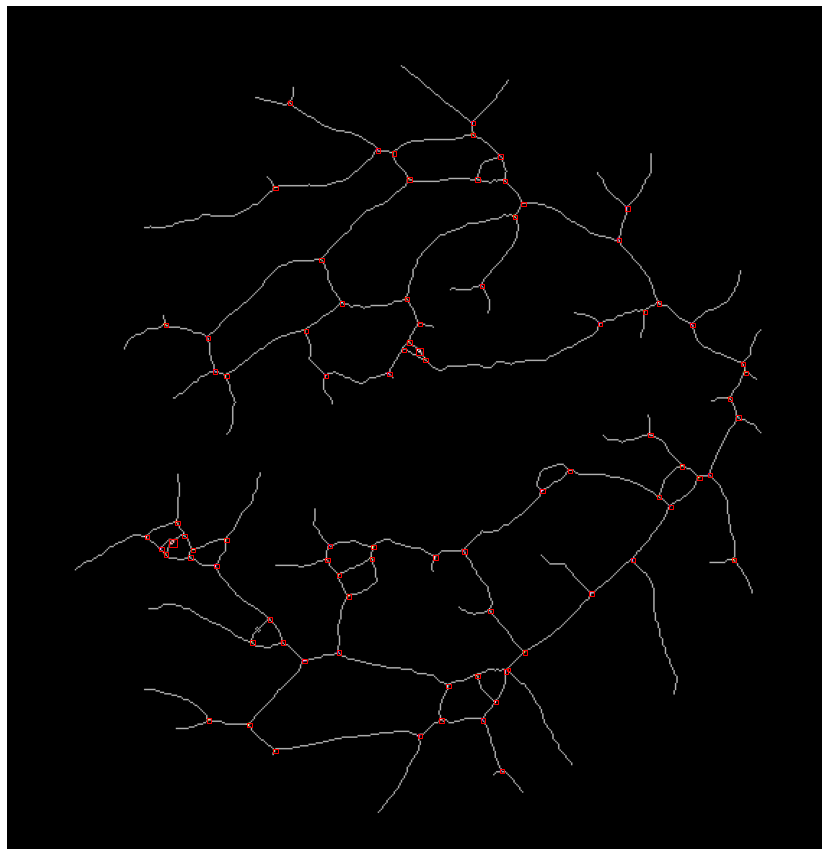

<Figure size 1440x1440 with 0 Axes>

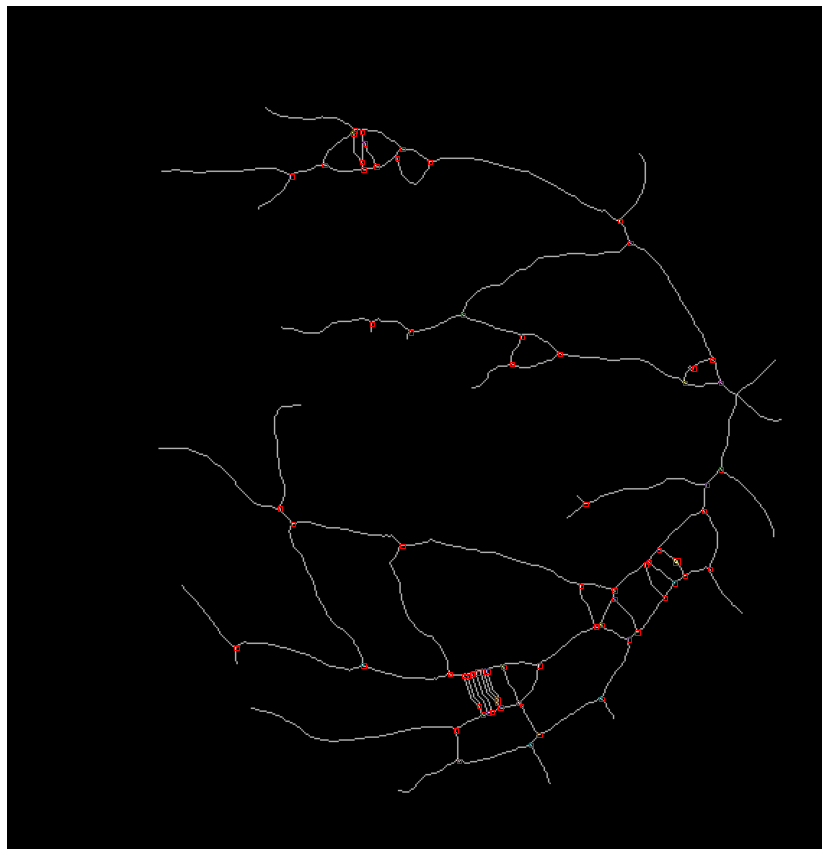

<Figure size 1440x1440 with 0 Axes>

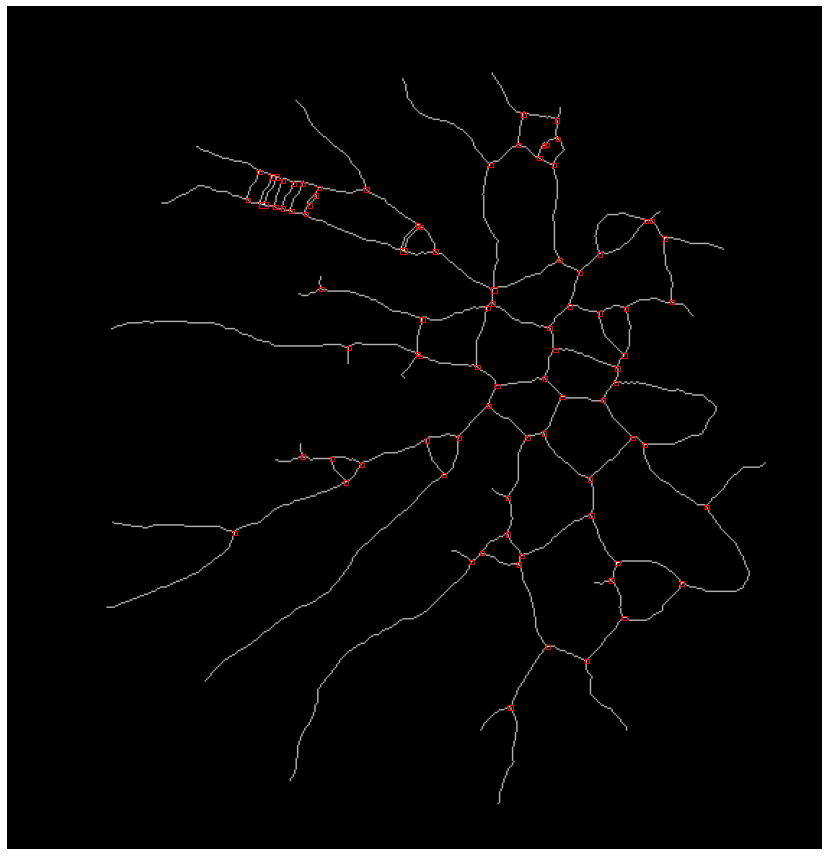

<Figure size 1440x1440 with 0 Axes>

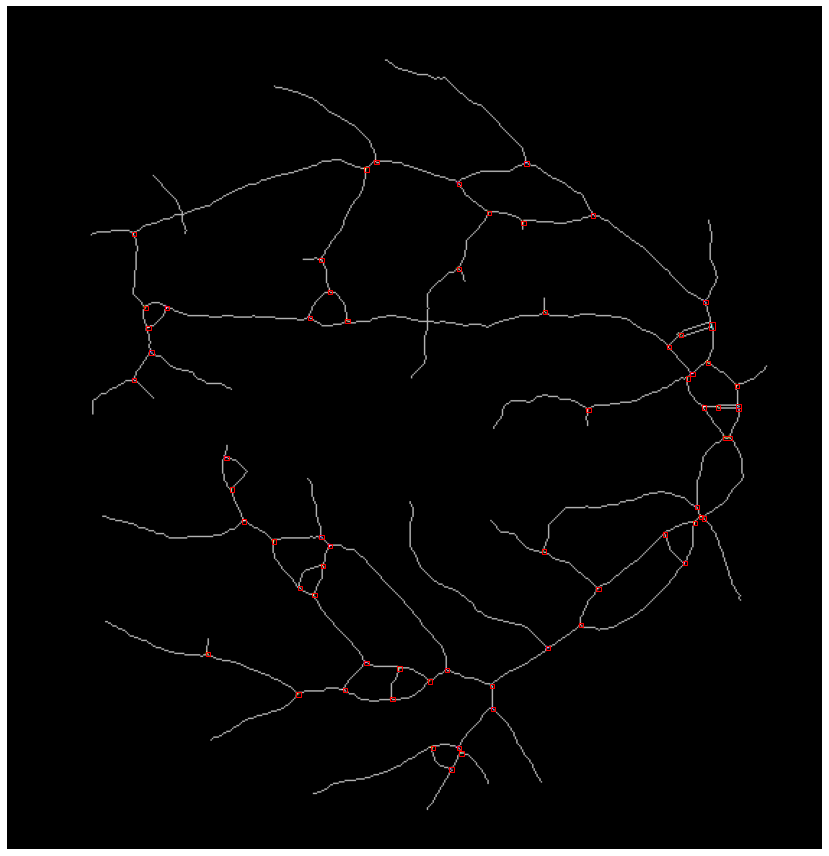

<Figure size 1440x1440 with 0 Axes>

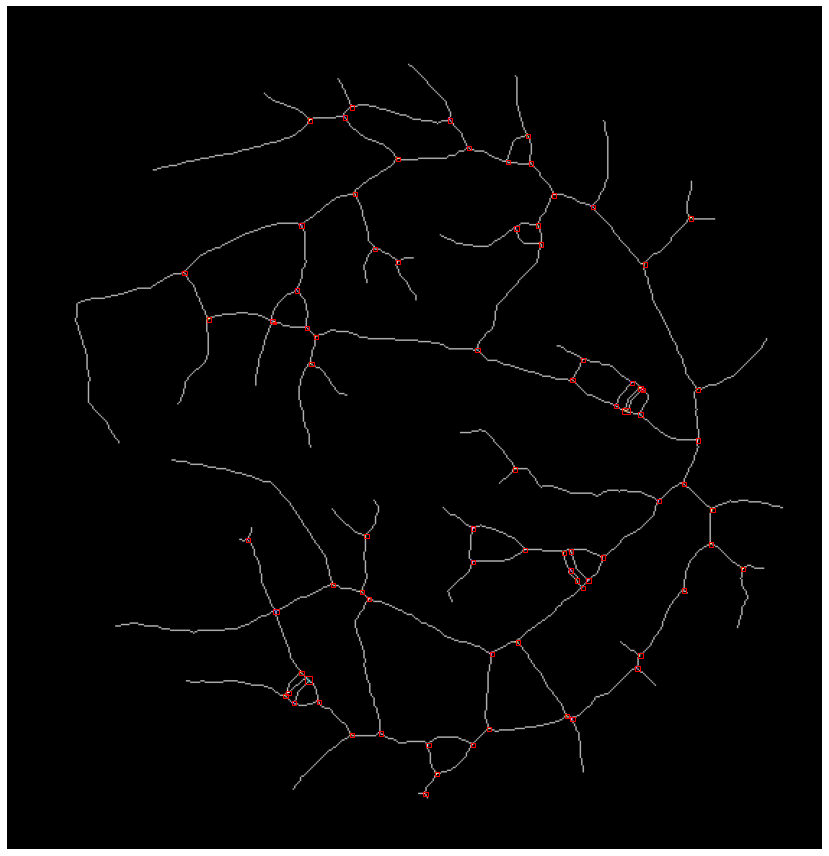

<Figure size 1440x1440 with 0 Axes>

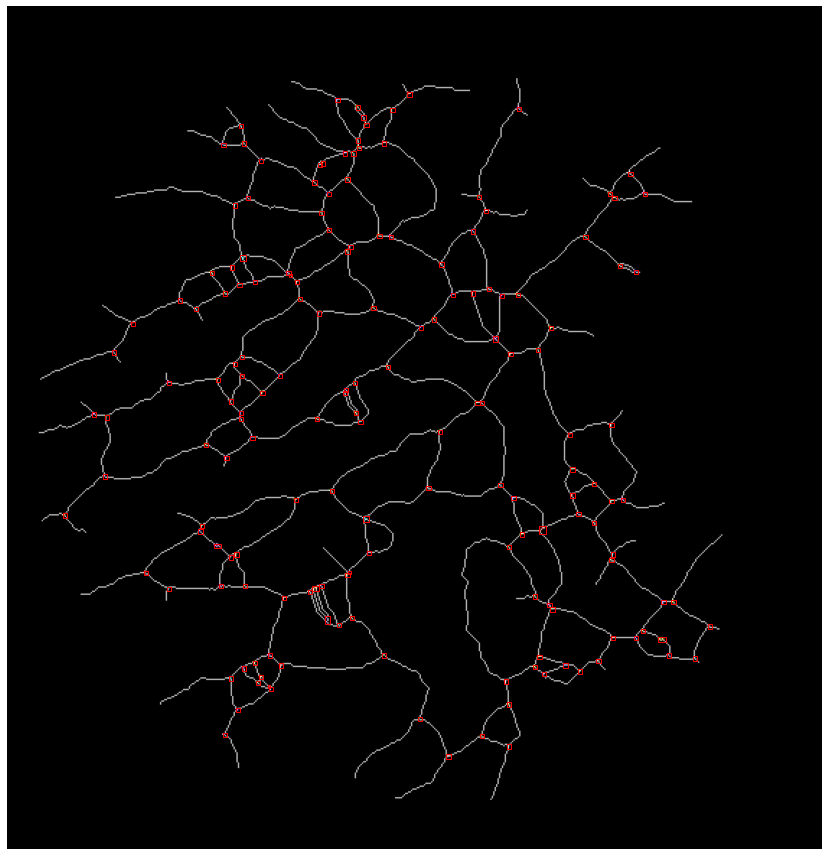

<Figure size 1440x1440 with 0 Axes>

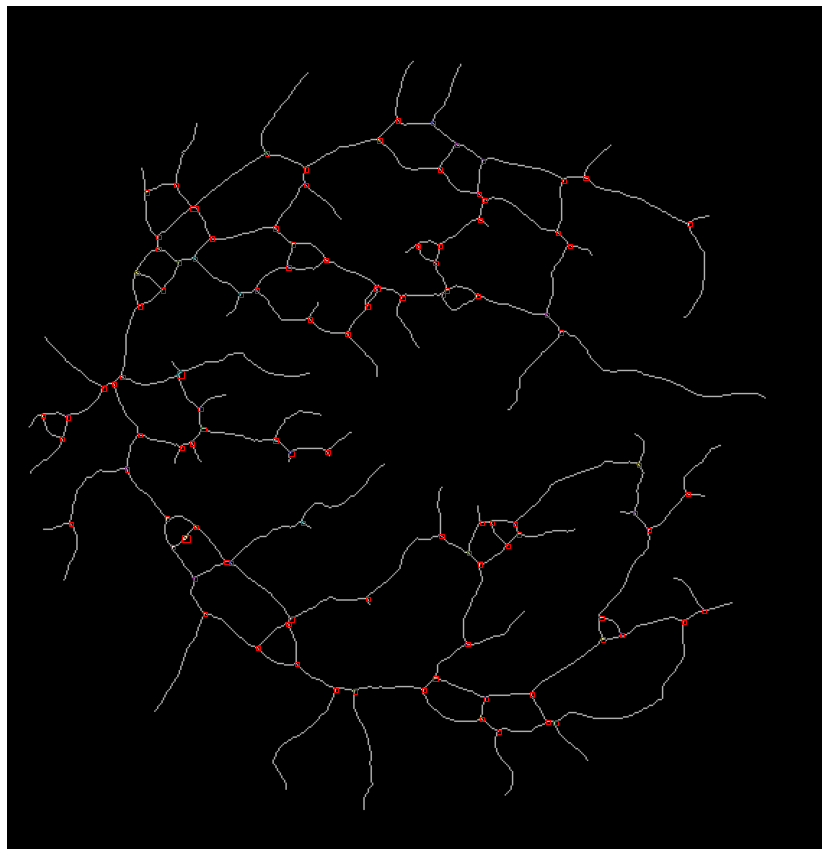

<Figure size 1440x1440 with 0 Axes>

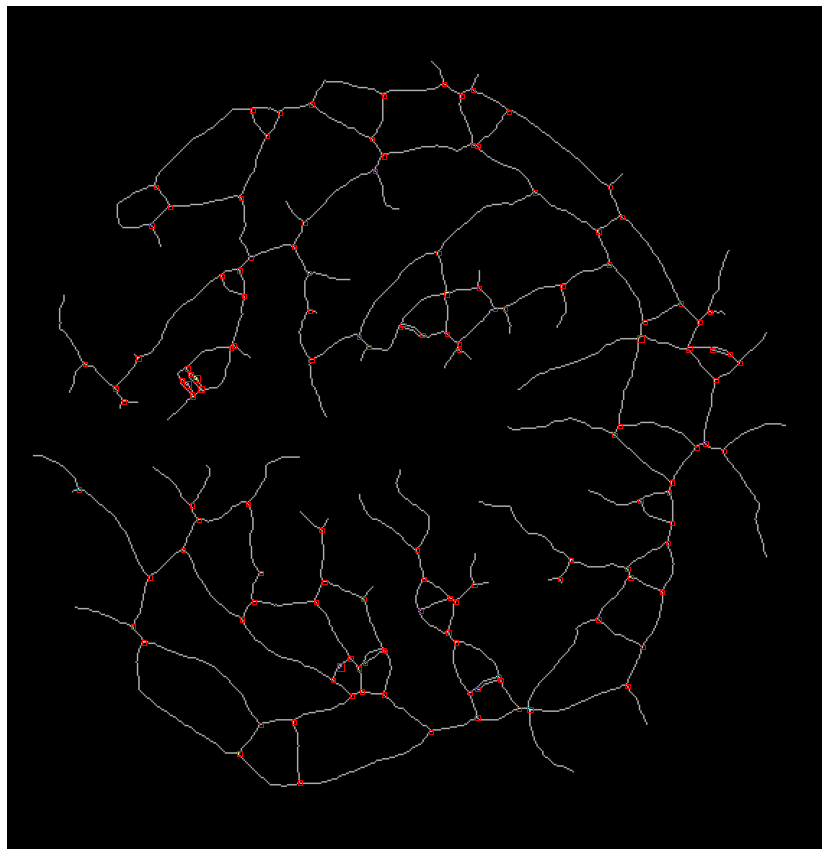

<Figure size 1440x1440 with 0 Axes>

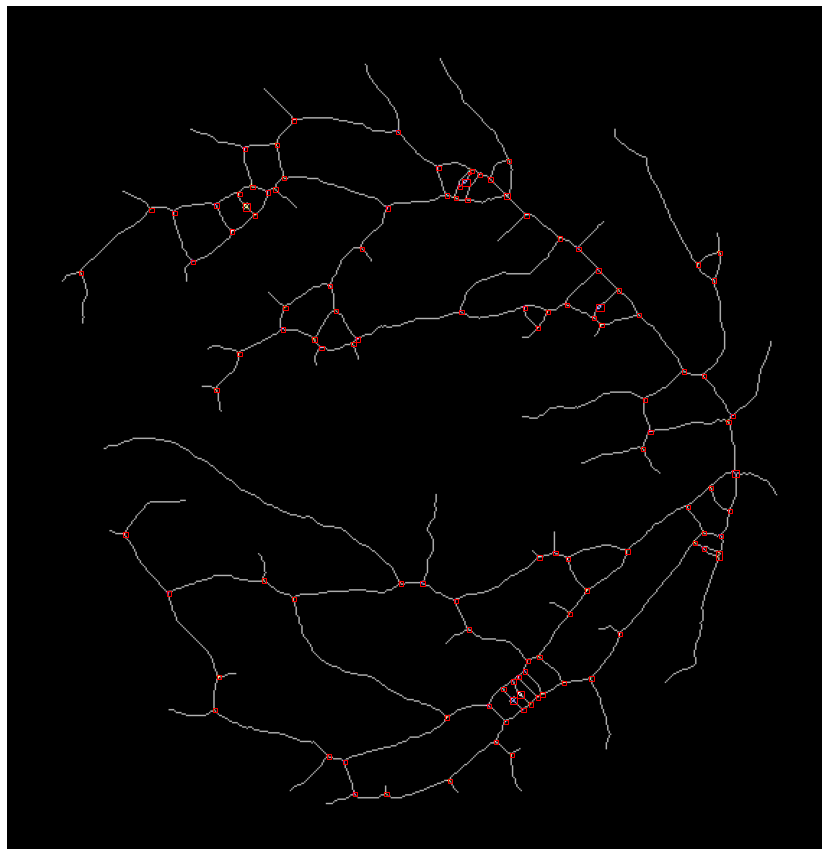

<Figure size 1440x1440 with 0 Axes>

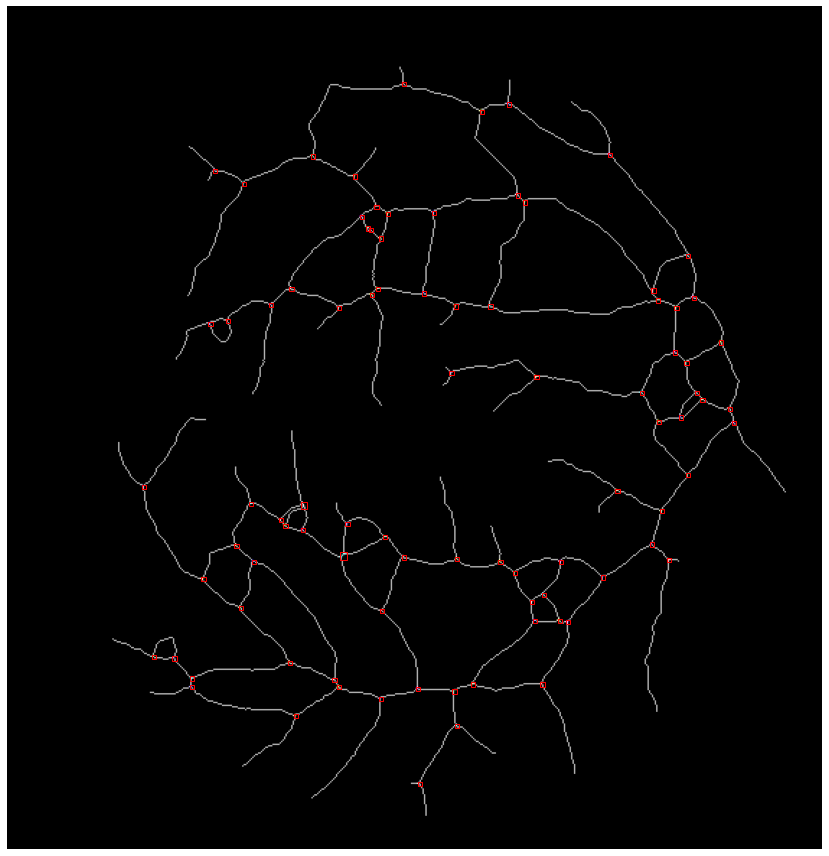

<Figure size 1440x1440 with 0 Axes>

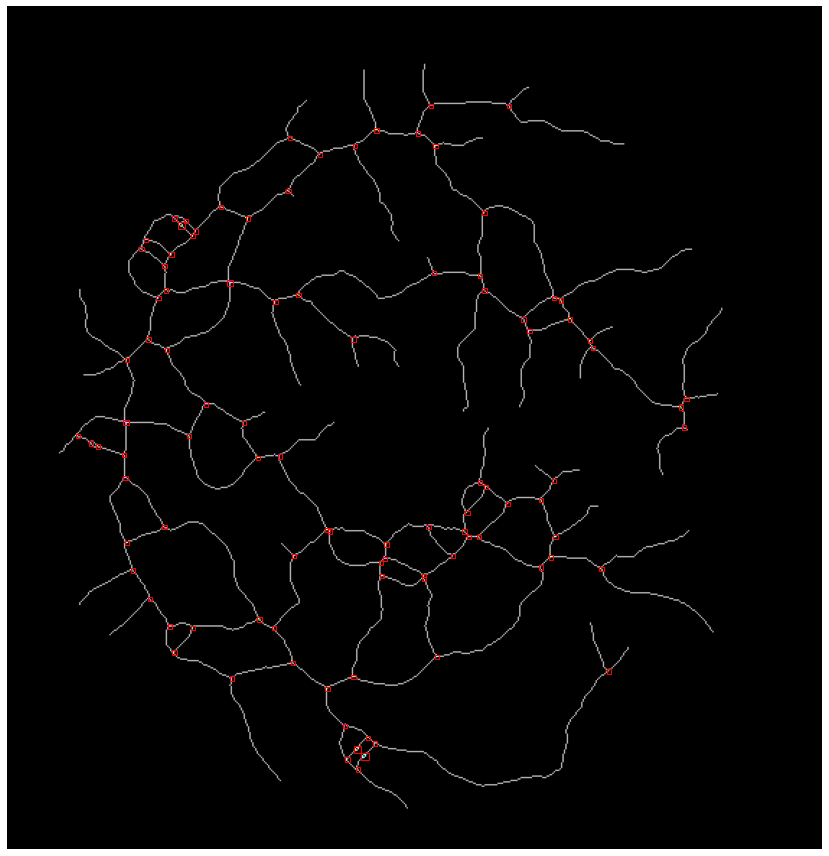

<Figure size 1440x1440 with 0 Axes>

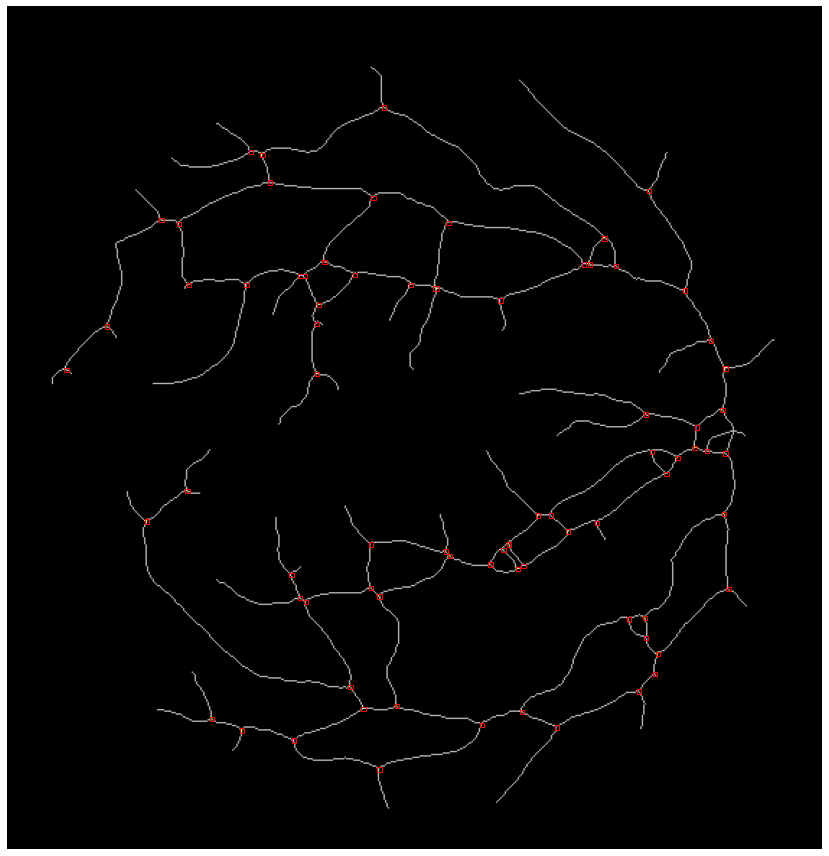

In [19]:
for i in range(21, 41):
    detection(i,bifurcations_list)

<Figure size 1440x1440 with 0 Axes>

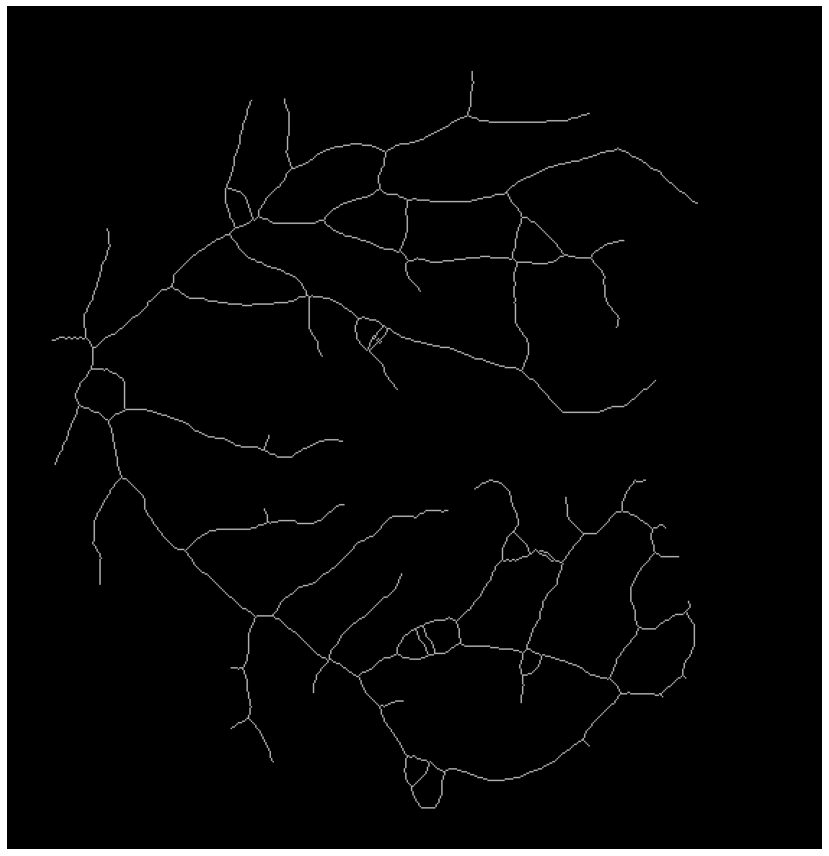

<Figure size 1440x1440 with 0 Axes>

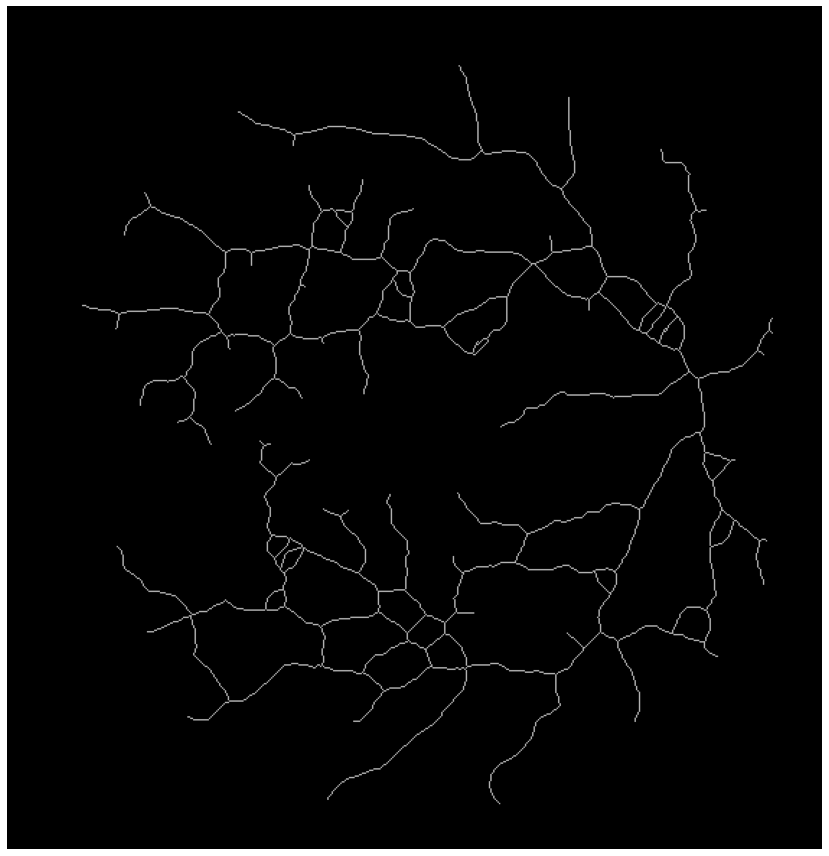

<Figure size 1440x1440 with 0 Axes>

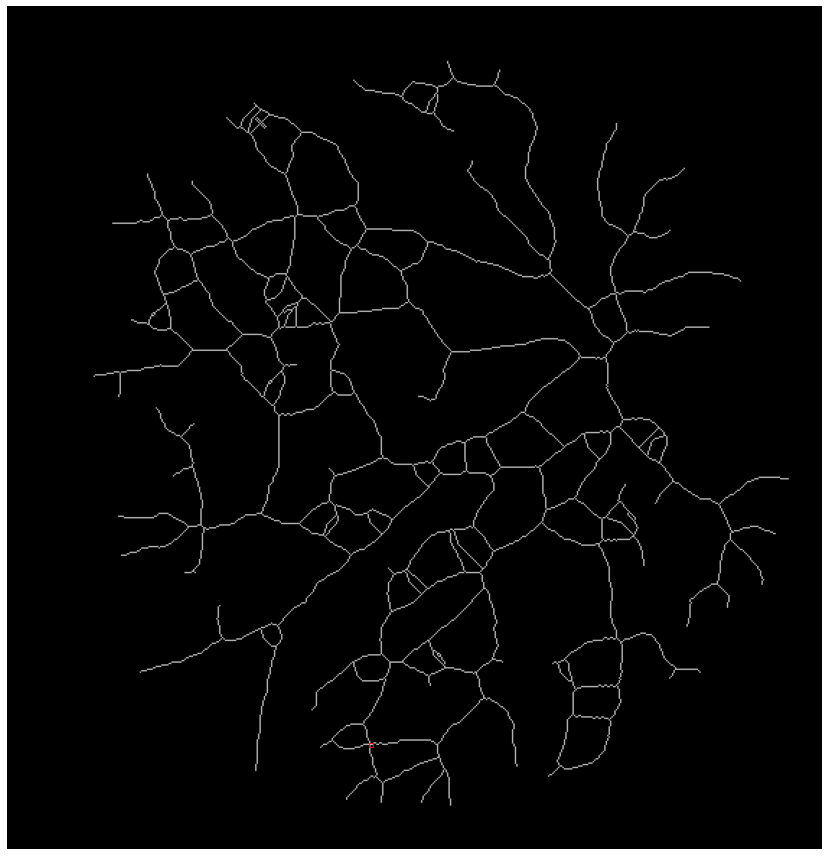

<Figure size 1440x1440 with 0 Axes>

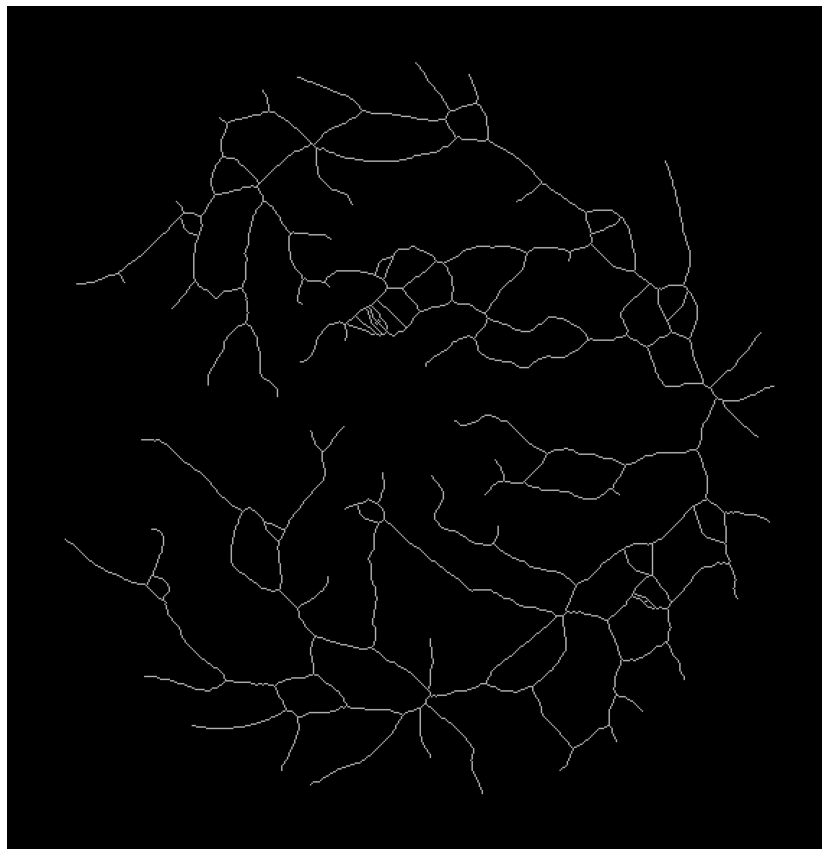

<Figure size 1440x1440 with 0 Axes>

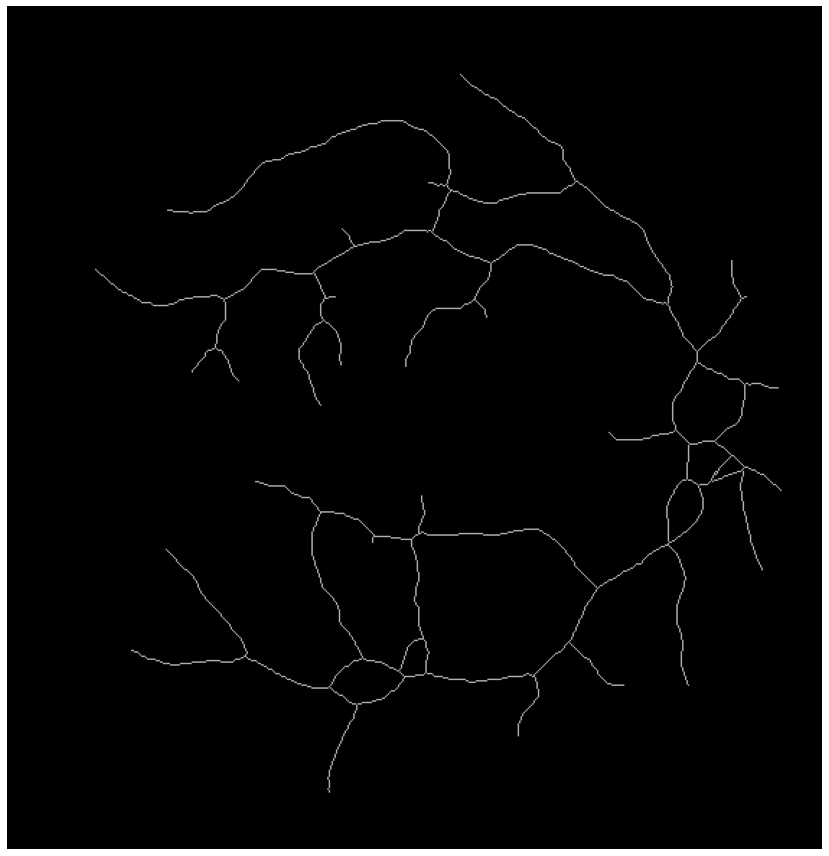

<Figure size 1440x1440 with 0 Axes>

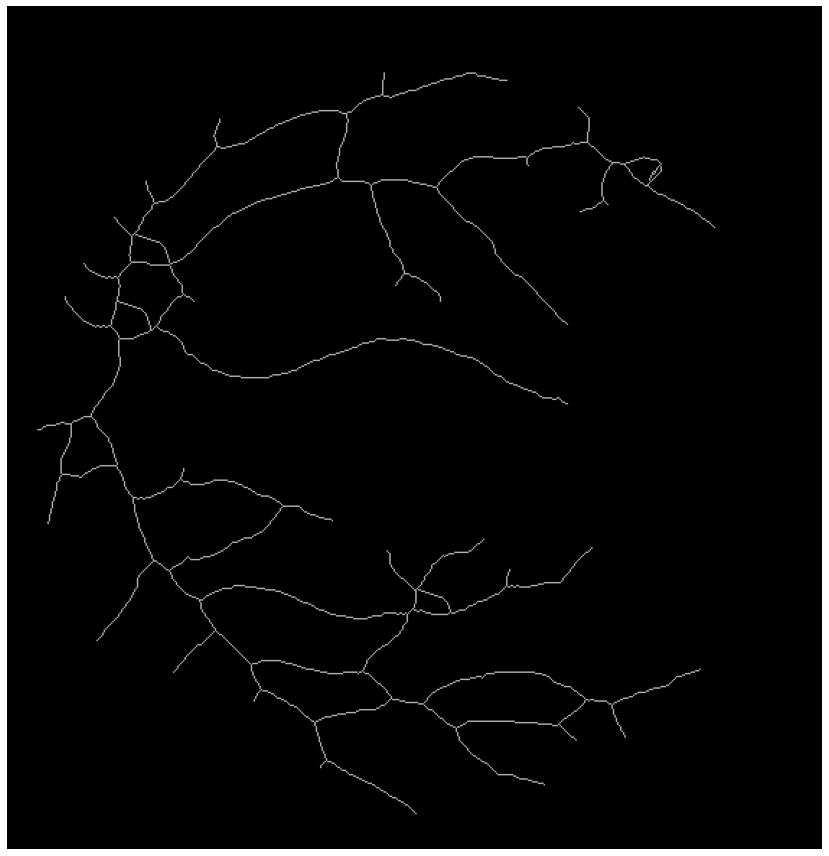

<Figure size 1440x1440 with 0 Axes>

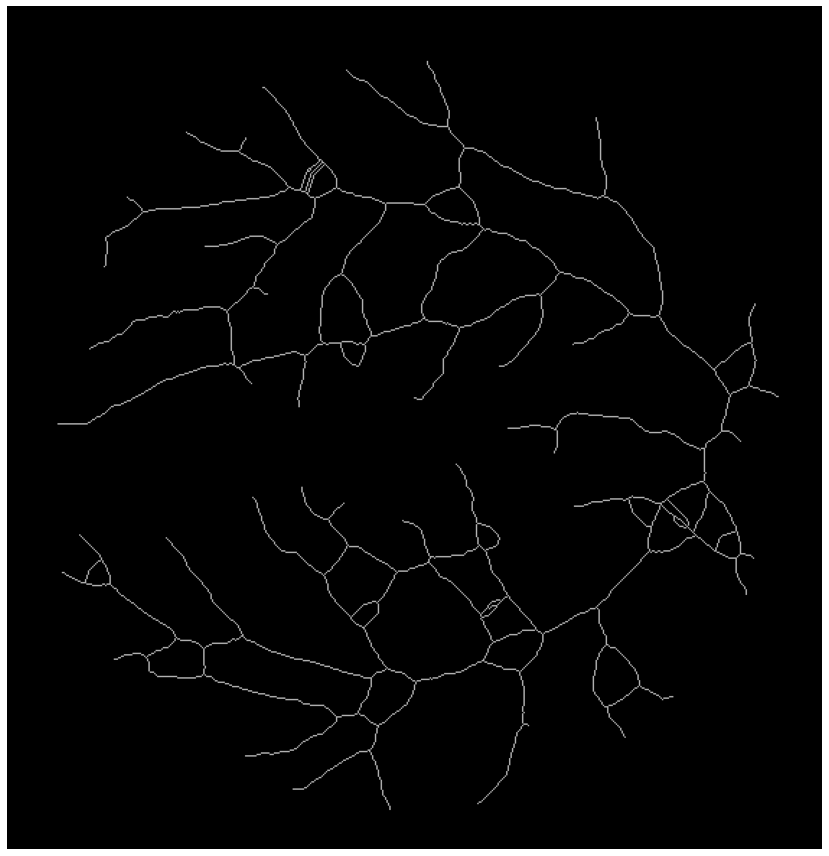

<Figure size 1440x1440 with 0 Axes>

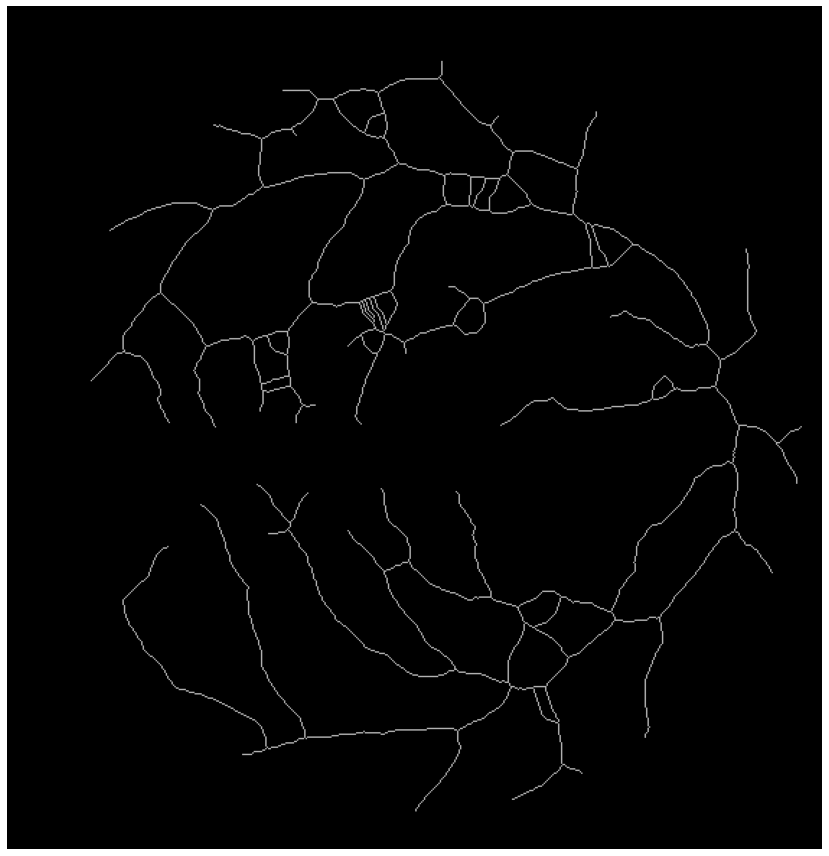

<Figure size 1440x1440 with 0 Axes>

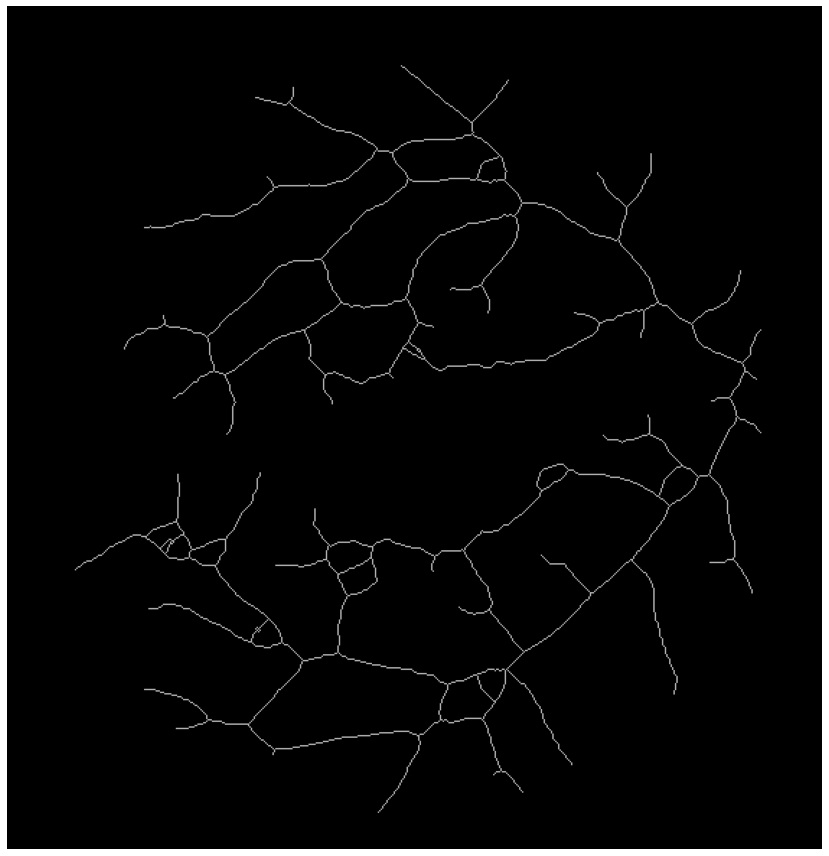

<Figure size 1440x1440 with 0 Axes>

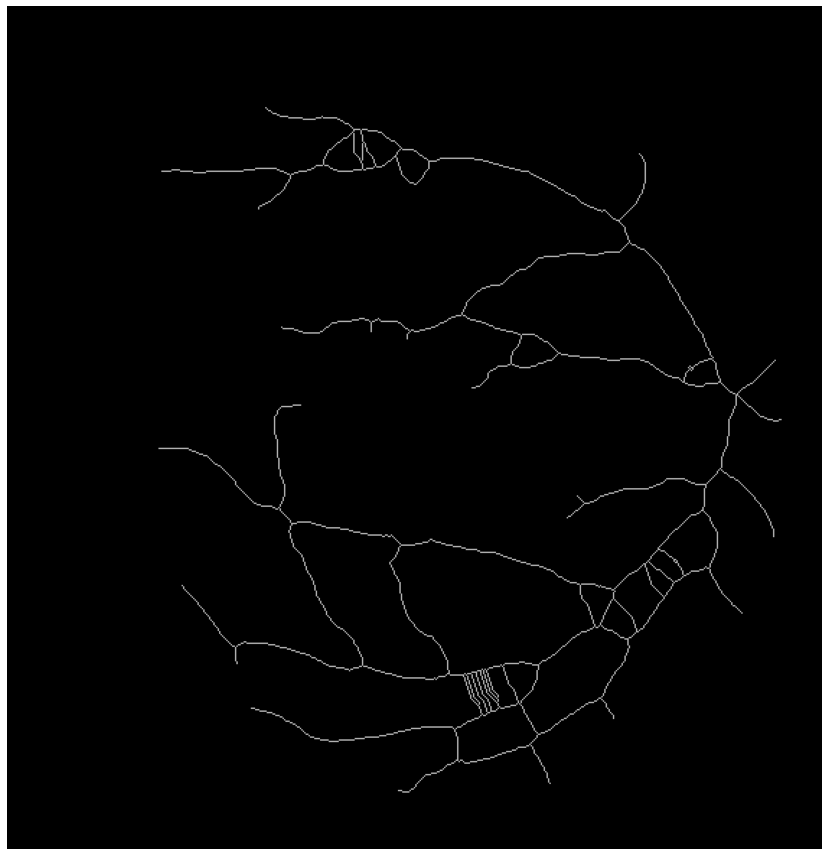

<Figure size 1440x1440 with 0 Axes>

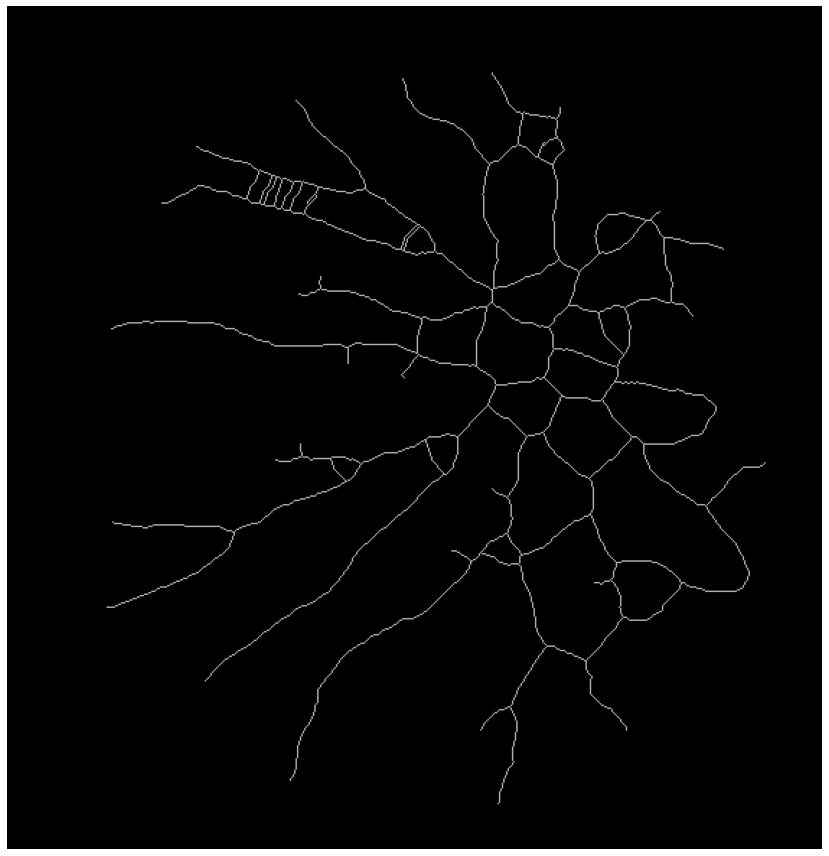

<Figure size 1440x1440 with 0 Axes>

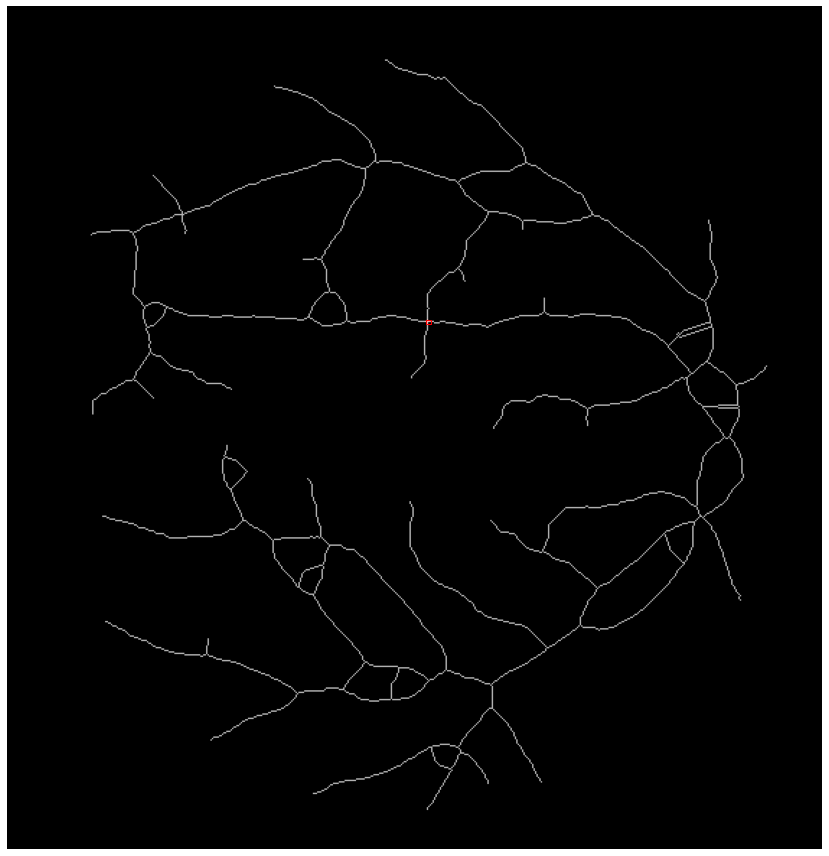

<Figure size 1440x1440 with 0 Axes>

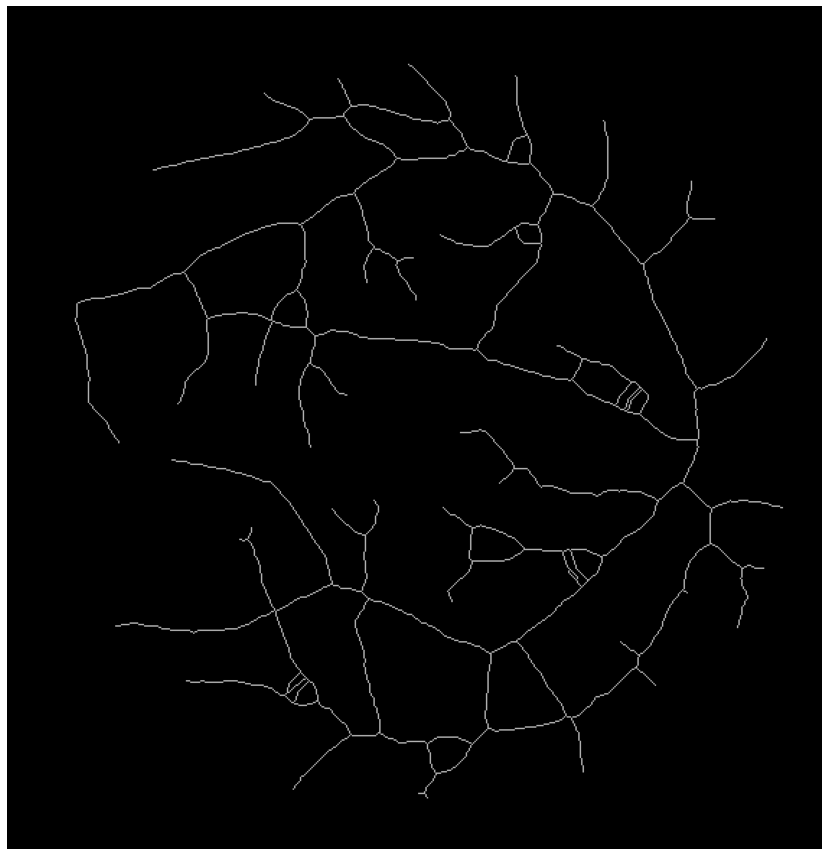

<Figure size 1440x1440 with 0 Axes>

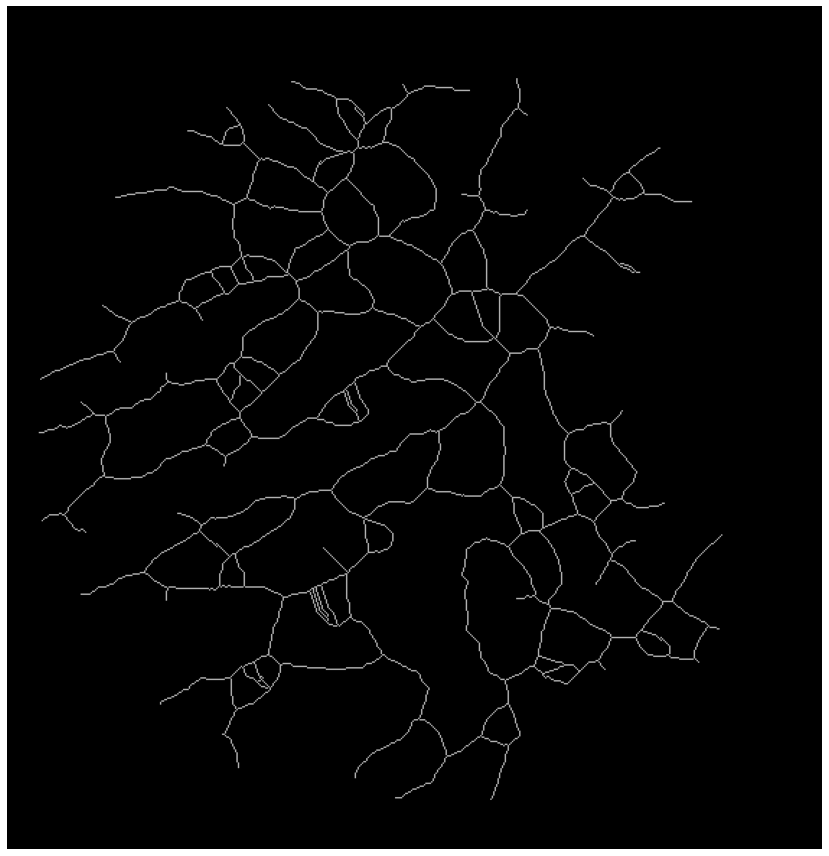

<Figure size 1440x1440 with 0 Axes>

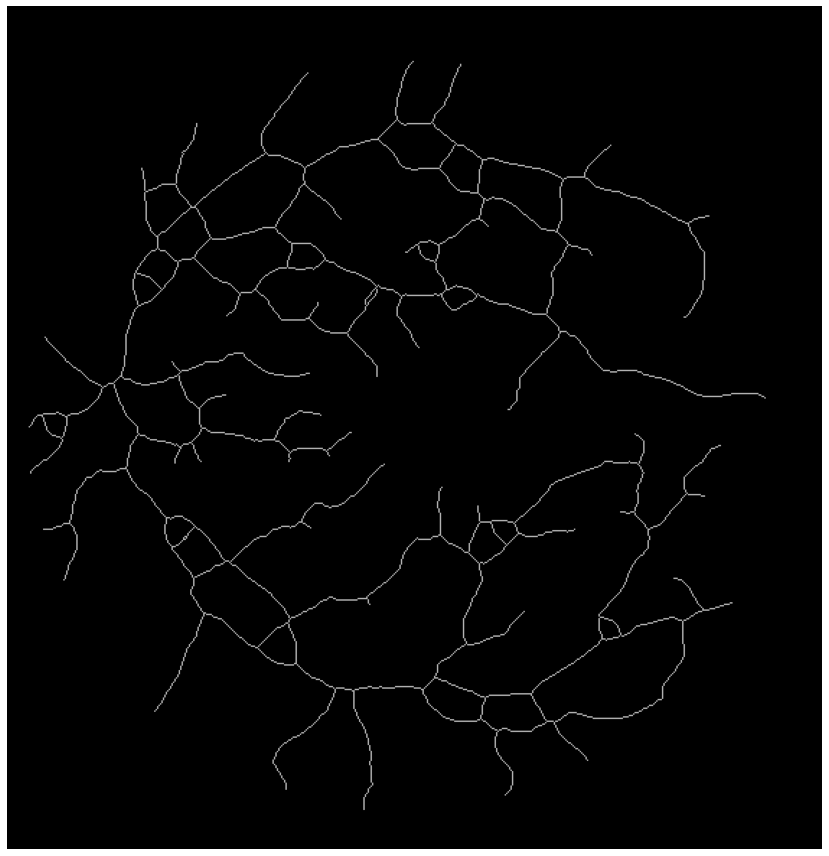

<Figure size 1440x1440 with 0 Axes>

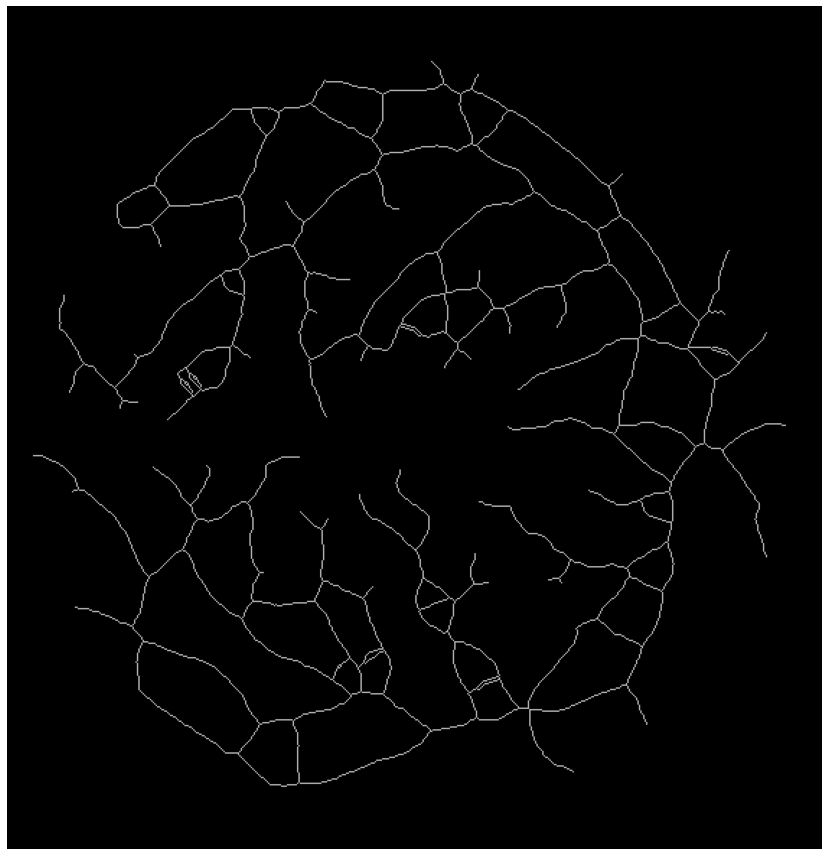

<Figure size 1440x1440 with 0 Axes>

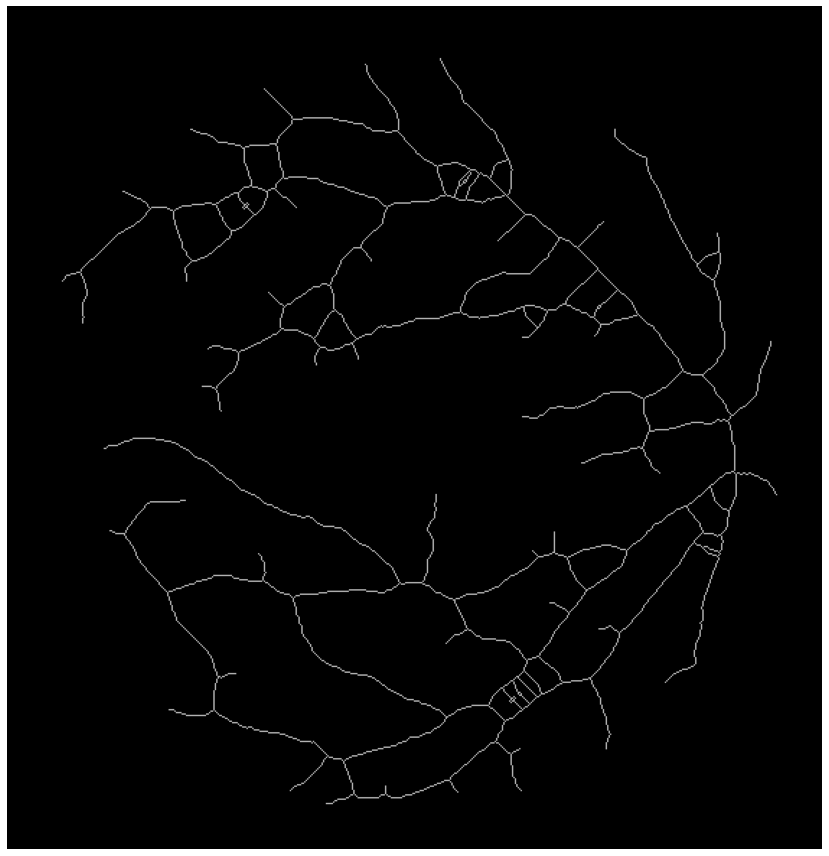

<Figure size 1440x1440 with 0 Axes>

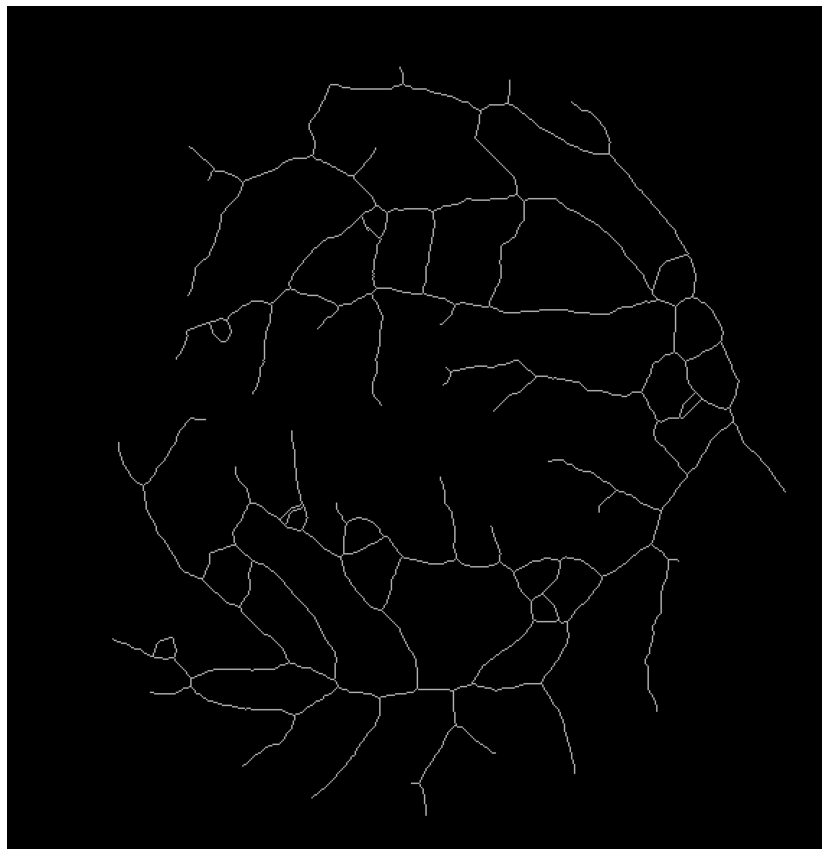

<Figure size 1440x1440 with 0 Axes>

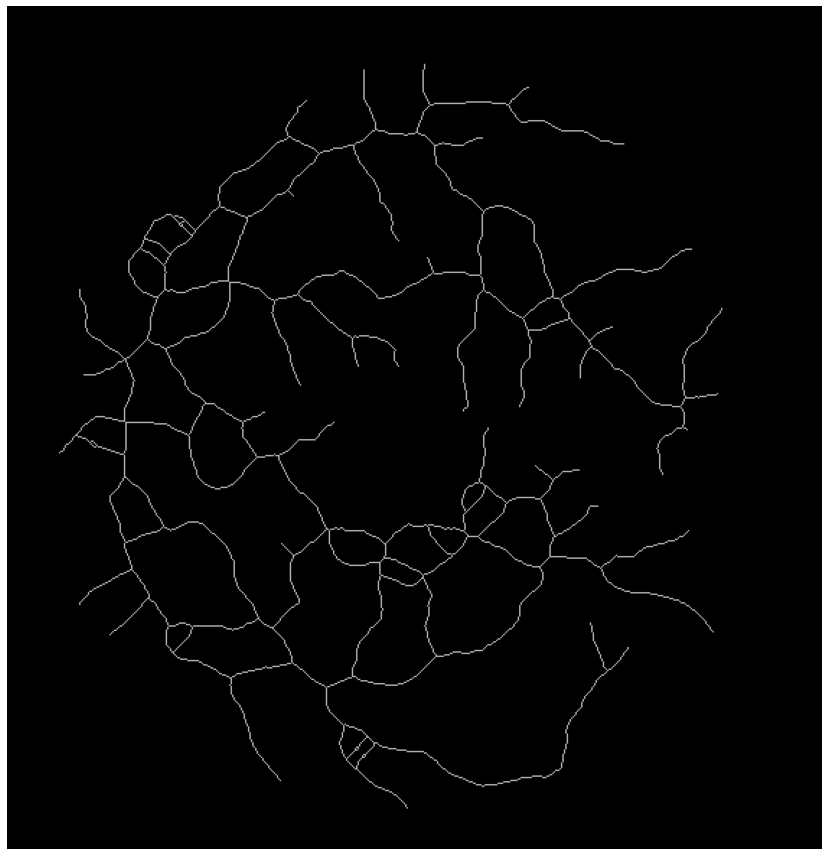

<Figure size 1440x1440 with 0 Axes>

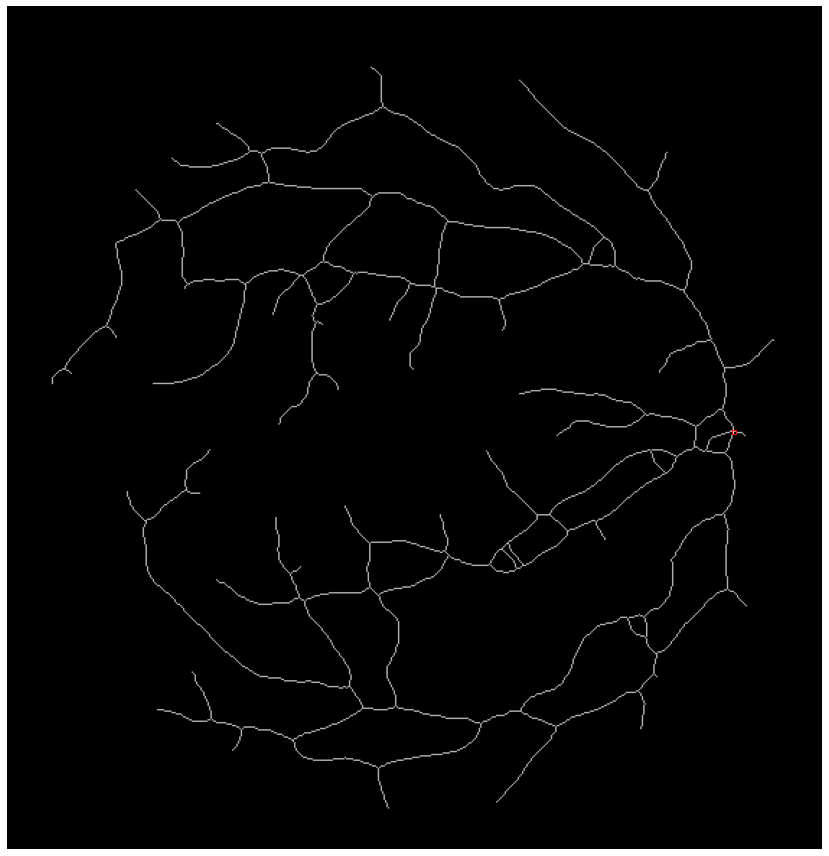

In [20]:
for i in range(21, 41):
    detection(i,crossover_list)